In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-tweets-for-sentiment-analysis-and-prediction/stock_yfinance_data.csv
/kaggle/input/stock-tweets-for-sentiment-analysis-and-prediction/stock_tweets.csv


In [12]:
import pandas as pd

# Load the CSV files
tweets_df = pd.read_csv('/kaggle/input/stock-tweets-for-sentiment-analysis-and-prediction/stock_tweets.csv')
yfinance_df = pd.read_csv('/kaggle/input/stock-tweets-for-sentiment-analysis-and-prediction/stock_yfinance_data.csv')

In [13]:


# Display unique values for each column in tweets_df
print("=== stock_tweets.csv ===")
for col in tweets_df.columns:
    print(f"\nUnique values in column '{col}':")
    print(tweets_df[col].unique())

# Display unique values for each column in yfinance_df
print("\n=== stock_yfinance_data.csv ===")
for col in yfinance_df.columns:
    print(f"\nUnique values in column '{col}':")
    print(yfinance_df[col].unique())


=== stock_tweets.csv ===

Unique values in column 'Date':
['2022-09-29 23:41:16+00:00' '2022-09-29 23:24:43+00:00'
 '2022-09-29 23:18:08+00:00' ... '2021-10-01 04:43:41+00:00'
 '2021-10-01 00:03:32+00:00' '2021-09-30 10:22:52+00:00']

Unique values in column 'Tweet':
['Mainstream media has done an amazing job at brainwashing people. Today at work, we were asked what companies we believe in &amp; I said @Tesla because they make the safest cars &amp; EVERYONE disagreed with me because they heard“they catch on fire &amp; the batteries cost 20k to replace”'
 'Tesla delivery estimates are at around 364k from the analysts. $tsla'
 '3/ Even if I include 63.0M unvested RSUs as of 6/30, additional equity needed for the RSUs is 63.0M x $54.20 = $3.4B. If the deal closed tomorrow at $54.20, Elon would need $2.0B for existing shares plus $3.4B for RSUs, so $5.4B new equity. $twtr $tsla'
 ...
 'Our record delivery results are a testimony of our unwavering pursuit of safety, quality, and customer ex

In [14]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop = set(stopwords.words('english'))
lem = WordNetLemmatizer()
def clean_tweet(t):
    t = re.sub(r'http\S+|@\w+|\$\w+|#\w+', '', t)
    t = re.sub(r'[^\w\s]', '', t.lower())
    tokens = [lem.lemmatize(w) for w in word_tokenize(t) if w not in stop]
    return ' '.join(tokens)

tweets_df['cleaned'] = tweets_df['Tweet'].apply(clean_tweet)


In [15]:
import pandas as pd

# 1) Parse the raw Date strings into real datetime objects (and make them UTC‑aware)
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], utc=True)
yfinance_df['Date'] = pd.to_datetime(yfinance_df['Date'])

# 2) Now extract just the calendar date
tweets_df['Date_only'] = tweets_df['Date'].dt.date
yfinance_df['Date_only'] = yfinance_df['Date'].dt.date

# Quick check
print(tweets_df[['Date','Date_only']].head())
print(yfinance_df[['Date','Date_only']].head())
print(tweets_df[['Date','Date_only']].tail())
print(yfinance_df[['Date','Date_only']].tail())

                       Date   Date_only
0 2022-09-29 23:41:16+00:00  2022-09-29
1 2022-09-29 23:24:43+00:00  2022-09-29
2 2022-09-29 23:18:08+00:00  2022-09-29
3 2022-09-29 22:40:07+00:00  2022-09-29
4 2022-09-29 22:27:05+00:00  2022-09-29
        Date   Date_only
0 2021-09-30  2021-09-30
1 2021-10-01  2021-10-01
2 2021-10-04  2021-10-04
3 2021-10-05  2021-10-05
4 2021-10-06  2021-10-06
                           Date   Date_only
80788 2021-10-07 17:11:57+00:00  2021-10-07
80789 2021-10-04 17:05:59+00:00  2021-10-04
80790 2021-10-01 04:43:41+00:00  2021-10-01
80791 2021-10-01 00:03:32+00:00  2021-10-01
80792 2021-09-30 10:22:52+00:00  2021-09-30
           Date   Date_only
6295 2022-09-23  2022-09-23
6296 2022-09-26  2022-09-26
6297 2022-09-27  2022-09-27
6298 2022-09-28  2022-09-28
6299 2022-09-29  2022-09-29


In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

MODEL_NAME = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()   # disable dropout


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
import torch

# 1️⃣ Detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 2️⃣ Send model to GPU
model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
def get_finbert_scores(text):
    # tokenize (CPU)…
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    # move inputs to GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    probs = torch.softmax(logits, dim=-1).cpu().numpy().squeeze()
    return {
        'fin_pos': float(probs[0]),
        'fin_neg': float(probs[1]),
        'fin_neu': float(probs[2])
    }

In [19]:
# ───────────────────────────────────────────────────────────────────────────────
# 4) Apply FinBERT to your cleaned tweets
#    (Note: on CPU this can be slow—
#consider sampling or batching.)
# ───────────────────────────────────────────────────────────────────────────────
# Map each cleaned tweet to its dict of scores
scores = tweets_df['cleaned'].map(get_finbert_scores).tolist()
scores_df = pd.DataFrame(scores)
# concat back into tweets_df
tweets_df = pd.concat([tweets_df.reset_index(drop=True), scores_df], axis=1)

In [20]:
# ───────────────────────────────────────────────────────────────────────────────
# A) Compute per‑tweet FinBERT scores and unpack nicely into 3 columns
# ───────────────────────────────────────────────────────────────────────────────
from tqdm.auto import tqdm
tqdm.pandas()

# Map returns a dict for each row; turn that list of dicts into a DataFrame
scores = tweets_df['cleaned'].progress_map(get_finbert_scores)
scores_df = pd.DataFrame(list(scores))  
# make sure the columns are exactly ['fin_pos','fin_neg','fin_neu']
print(scores_df.head())

# Attach those to your tweets_df
tweets_df = pd.concat([tweets_df, scores_df], axis=1)


  0%|          | 0/80793 [00:00<?, ?it/s]

    fin_pos       fin_neg   fin_neu
0  0.000098  9.998177e-01  0.000085
1  0.999979  4.066889e-07  0.000020
2  0.999982  1.570194e-05  0.000002
3  0.993644  2.479644e-04  0.006108
4  0.907892  9.059280e-04  0.091202


In [21]:
# # ───────────────────────────────────────────────────────────────────────────────
# # 5) Build a compound score + discrete label
# # ───────────────────────────────────────────────────────────────────────────────
# tweets_df['fin_compound'] = tweets_df['fin_pos'] - tweets_df['fin_neg']

# def fin_cat(c):
#     if   c >  0.05: return 'bullish'
#     elif c < -0.05: return 'bearish'
#     else:           return 'neutral'

# tweets_df['fin_sent_cat'] = tweets_df['fin_compound'].apply(fin_cat)

In [22]:
print(tweets_df.head())

                       Date  \
0 2022-09-29 23:41:16+00:00   
1 2022-09-29 23:24:43+00:00   
2 2022-09-29 23:18:08+00:00   
3 2022-09-29 22:40:07+00:00   
4 2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

                                             cleaned   Date_only   fin_pos  \
0  mainstream medium done amazing job brainwashin...  2022-09-29  0.000098   
1        tesla delivery estimate around 364k analyst  2022-09-29  0.999979   
2  3 even include 630m unvested rsus 630 addition...  2022-09-29  0.999982   
3  hahaha still tryi

In [23]:
# Step 1: Drop duplicate columns
tweets_df = tweets_df.loc[:, ~tweets_df.columns.duplicated()]
tweets_df.columns = tweets_df.columns.str.strip()  # remove whitespace just in case

# Step 2: Group by Date_only and Stock Name, summing the sentiment scores
daily_fin_scores = (
    tweets_df
    .groupby(['Date_only', 'Stock Name'], as_index=False)
    .agg({
        'fin_pos': 'sum',
        'fin_neg': 'sum',
        'fin_neu': 'sum'
    })
)

# Step 3: Add tweet count
daily_fin_scores['tweet_count'] = tweets_df.groupby(['Date_only', 'Stock Name']).size().values

# Final check
print(daily_fin_scores.head())

    Date_only Stock Name   fin_pos   fin_neg   fin_neu  tweet_count
0  2021-09-30       AAPL  5.094928  0.969879  0.935192            7
1  2021-09-30        AMD  2.727792  3.262099  0.010109            6
2  2021-09-30       AMZN  3.077200  1.002323  0.920477            5
3  2021-09-30        DIS  0.999918  0.000038  0.000044            1
4  2021-09-30       GOOG  0.803325  0.193206  0.003470            1


In [24]:
print(daily_fin_scores.columns)


Index(['Date_only', 'Stock Name', 'fin_pos', 'fin_neg', 'fin_neu',
       'tweet_count'],
      dtype='object')


In [25]:
for col in ['Date_only', 'Stock Name',
       'tweet_count']:
    print(f"\nUnique values in column '{col}':")
    print(daily_fin_scores[col].unique())


Unique values in column 'Date_only':
[datetime.date(2021, 9, 30) datetime.date(2021, 10, 1)
 datetime.date(2021, 10, 2) datetime.date(2021, 10, 3)
 datetime.date(2021, 10, 4) datetime.date(2021, 10, 5)
 datetime.date(2021, 10, 6) datetime.date(2021, 10, 7)
 datetime.date(2021, 10, 8) datetime.date(2021, 10, 9)
 datetime.date(2021, 10, 10) datetime.date(2021, 10, 11)
 datetime.date(2021, 10, 12) datetime.date(2021, 10, 13)
 datetime.date(2021, 10, 14) datetime.date(2021, 10, 15)
 datetime.date(2021, 10, 16) datetime.date(2021, 10, 17)
 datetime.date(2021, 10, 18) datetime.date(2021, 10, 19)
 datetime.date(2021, 10, 20) datetime.date(2021, 10, 21)
 datetime.date(2021, 10, 22) datetime.date(2021, 10, 23)
 datetime.date(2021, 10, 24) datetime.date(2021, 10, 25)
 datetime.date(2021, 10, 26) datetime.date(2021, 10, 27)
 datetime.date(2021, 10, 28) datetime.date(2021, 10, 29)
 datetime.date(2021, 10, 30) datetime.date(2021, 10, 31)
 datetime.date(2021, 11, 1) datetime.date(2021, 11, 2)
 date

In [26]:
# Ensure yfinance_df has Date_only
yfinance_df['Date_only'] = yfinance_df['Date'].dt.date

# Merge the daily sentiment into the stock data
df = (
    yfinance_df
    .merge(daily_fin_scores, on=['Date_only', 'Stock Name'], how='left')
    .sort_values(['Stock Name', 'Date_only'])
)

# Fill in missing sentiment (e.g., for non-tweeting days)
df[['fin_pos', 'fin_neg', 'fin_neu']] = df[['fin_pos', 'fin_neg', 'fin_neu']].fillna(0)
df['tweet_count'] = df['tweet_count'].fillna(0)

# Final preview
print(df[['Date_only', 'Stock Name', 'Close', 'fin_pos', 'fin_neg', 'fin_neu', 'tweet_count']].head())


       Date_only Stock Name       Close   fin_pos   fin_neg   fin_neu  \
1764  2021-09-30       AAPL  141.500000  5.094928  0.969879  0.935192   
1765  2021-10-01       AAPL  142.649994  8.168377  1.002193  1.829429   
1766  2021-10-04       AAPL  139.139999  7.671401  1.179448  1.149150   
1767  2021-10-05       AAPL  141.110001  4.928896  0.070702  0.000401   
1768  2021-10-06       AAPL  142.000000  8.772582  1.008843  0.218575   

      tweet_count  
1764          7.0  
1765         11.0  
1766         10.0  
1767          5.0  
1768         10.0  


In [27]:
print(df.head())

           Date        Open        High         Low       Close   Adj Close  \
1764 2021-09-30  143.660004  144.380005  141.279999  141.500000  140.478485   
1765 2021-10-01  141.899994  142.919998  139.110001  142.649994  141.620163   
1766 2021-10-04  141.759995  142.210007  138.270004  139.139999  138.135513   
1767 2021-10-05  139.490005  142.240005  139.360001  141.110001  140.091278   
1768 2021-10-06  139.470001  142.149994  138.369995  142.000000  140.974869   

        Volume Stock Name   Date_only   fin_pos   fin_neg   fin_neu  \
1764  89056700       AAPL  2021-09-30  5.094928  0.969879  0.935192   
1765  94639600       AAPL  2021-10-01  8.168377  1.002193  1.829429   
1766  98322000       AAPL  2021-10-04  7.671401  1.179448  1.149150   
1767  80861100       AAPL  2021-10-05  4.928896  0.070702  0.000401   
1768  83221100       AAPL  2021-10-06  8.772582  1.008843  0.218575   

      tweet_count  
1764          7.0  
1765         11.0  
1766         10.0  
1767          5.0 

In [28]:
import os
import time
import numpy as np
import pandas as pd
import ta                             # pip install ta
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LSTM, GRU,
    TimeDistributed, Concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    max_error
)
import matplotlib.pyplot as plt

In [29]:
# --- 1. Parameters and feature list --- #
sequence_length = 20
batch_size = 16

feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
    'fin_pos', 'fin_neg', 'fin_neu', 'tweet_count'
]

In [30]:
# assume `df` is already your DataFrame with Date, Stock Name, all feature_cols

# 1a) preserve true next‑day Close in a separate column
df['raw_Close'] = df['Close'].values

# 1b) scale each feature column in‑place
feature_scalers = {}
for col in feature_cols:
    scaler = RobustScaler()
    df[col] = scaler.fit_transform(df[[col]])
    feature_scalers[col] = scaler

# --- 2. Build sliding windows of features + raw target --- #
X_list, y_list = [], []

for stock, group in df.groupby('Stock Name'):
    group = group.sort_values('Date')
    feats  = group[feature_cols].values
    closes = group['raw_Close'].values
    for i in range(len(group) - sequence_length):
        X_list.append(feats[i : i + sequence_length])
        y_list.append(closes[i + sequence_length])

X_all = np.array(X_list)                 # (n_samples, 20, num_features)
y_all = np.array(y_list, dtype=float).reshape(-1, 1)   # (n_samples, 1)

# --- 3. Scale the target separately --- #
y_scaler      = RobustScaler()
y_all_scaled  = y_scaler.fit_transform(y_all)

# --- 4. Train/test split (80/20), time‑ordered --- #
n = len(X_all)
split = int(0.8 * n)

X_train_full       = X_all[:split]
y_train_full_scaled= y_all_scaled[:split]
X_test             = X_all[split:]
y_test_scaled      = y_all_scaled[split:]
y_test_raw         = y_all[split:].flatten()   # keep true prices for eval/plots

In [31]:
# --- 5. Further split train → (train, val) 80/20 --- #
train_n = len(X_train_full)
val_n   = int(0.2 * train_n)

X_train = X_train_full[:-val_n]
y_train = y_train_full_scaled[:-val_n]

X_val   = X_train_full[-val_n:]
y_val   = y_train_full_scaled[-val_n:]

# --- 6. Build tf.data pipelines (drop_remainder=True!) --- #
train_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_train, y_train))
      .shuffle(10_000)
      .batch(batch_size, drop_remainder=True)
)
val_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_val, y_val))
      .batch(batch_size, drop_remainder=True)
)

# (We’ll evaluate on raw arrays so test can be any size.)

I0000 00:00:1745137680.083009     918 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12986 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745137680.083642     918 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [32]:
# --- 7. Custom callback to time epochs (optional) --- #
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.train_start = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        t = time.time() - self.epoch_start
        self.epoch_times.append(t)
        print(f"Epoch {epoch+1} took {t:.2f}s  —  loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

    def on_train_end(self, logs=None):
        total = time.time() - self.train_start
        print(f"Training done in {total:.2f}s; avg epoch {np.mean(self.epoch_times):.2f}s")

time_cb = TimeHistory()
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# --- 8. Build & compile the model under MirroredStrategy --- #
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    inp = Input(shape=(sequence_length, len(feature_cols)))
    x = TimeDistributed(Dense(64, activation='selu'))(inp)

    # short‑term branch
    st = Lambda(lambda x: x[:, -5:, :])(x)
    sb = GRU(64, return_sequences=True, recurrent_dropout=0.2)(st)
    sb = GRU(32, recurrent_dropout=0.1)(sb)

    # long‑term branch
    lb = LSTM(128, return_sequences=True, recurrent_dropout=0.2)(x)
    lb = LSTM(64,  return_sequences=True, recurrent_dropout=0.1)(lb)
    lb = LSTM(32,  recurrent_dropout=0.1)(lb)

    merged = Concatenate()([sb, lb])
    d1 = Dense(32, activation='selu')(merged)
    out= Dense(1)(d1)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(5e-4),
        loss=Huber(delta=1.5),
        metrics=['mae']
    )


In [33]:
# --- 9. Train --- #
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, time_cb],
    verbose=1
)

# --- 10. Evaluate & predict (and inverse‑transform) --- #
# Scaled evaluation
loss_s, mae_s = model.evaluate(X_test, y_test_scaled, verbose=0)
print(f"\nTest (scaled) — loss: {loss_s:.4f}, MAE: {mae_s:.4f}")

# Predict + inverse‑scale
y_pred_scaled = model.predict(X_test, verbose=0)
y_pred_raw    = y_scaler.inverse_transform(y_pred_scaled).flatten()

# True‑scale metrics
mae_val  = mean_absolute_error(y_test_raw, y_pred_raw)
mse_val  = mean_squared_error(  y_test_raw, y_pred_raw)
r2_val   = r2_score(            y_test_raw, y_pred_raw)
max_err  = max_error(           y_test_raw, y_pred_raw)
mape_val = np.mean(
    np.abs((y_test_raw - y_pred_raw) / np.where(y_test_raw==0,1,y_test_raw))
) * 100

print(f"Test MAE: {mae_val:.4f}")
print(f"Test MSE: {mse_val:.4f}")
print(f"Test R²:  {r2_val:.4f}")
print(f"Test MaxError: {max_err:.4f}")
print(f"Test MAPE: {mape_val:.2f}%\n")

Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0424 - mae: 0.1816Epoch 1 took 36.21s  —  loss=0.0164, val_loss=0.0331
232/232 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.0423 - mae: 0.1813 - val_loss: 0.0331 - val_mae: 0.1878
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0064 - mae: 0.0807Epoch 2 took 20.24s  —  loss=0.0057, val_loss=0.0076
232/232 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.0064 - mae: 0.0807 - val_loss: 0.0076 - val_mae: 0.0944
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0045 - mae: 0.0667Epoch 3 took 20.11s  —  loss=0.0045, val_loss=0.0096
232/232 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.0045 - mae: 0.0667 - val_loss: 0.0096 - val_mae: 0.0986
Epoch 4/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0037 - mae: 0.0605Epoch 4 took 19.66s  —  loss=0.0041, val_loss=0.0054
232/232 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.0037 - mae: 0.0605 - val_loss: 0.0054 - val_mae: 0.0836
Epoch 5/100
232/232 ━━━━

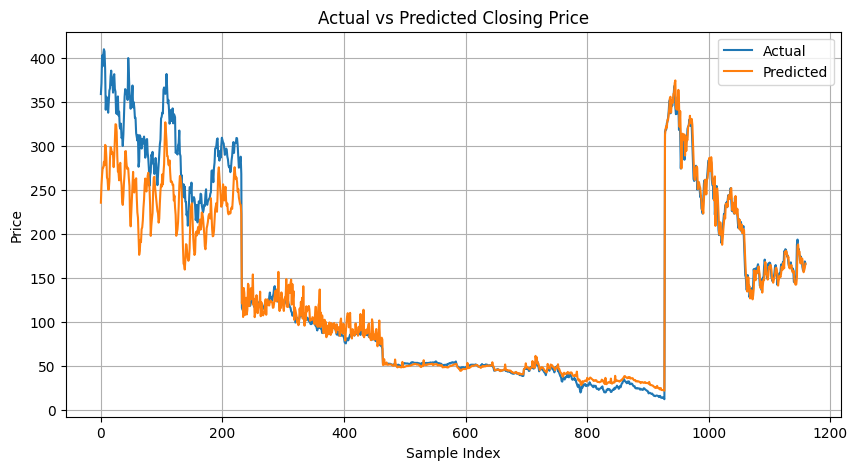

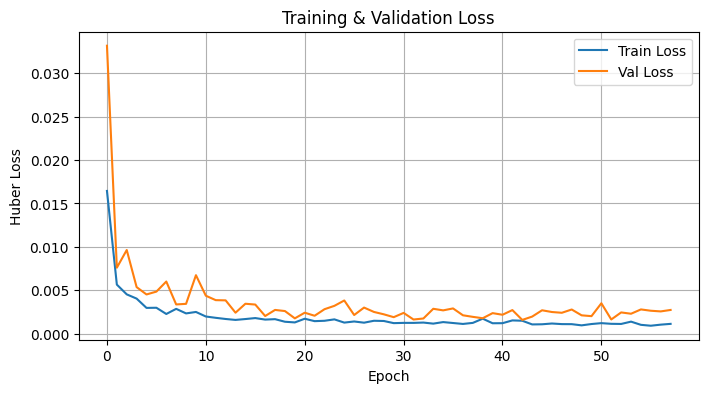

In [34]:
# --- 11. Plots --- #
plt.figure(figsize=(10,5))
plt.plot(y_test_raw, label='Actual')
plt.plot(y_pred_raw, label='Predicted')
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True)
plt.show()

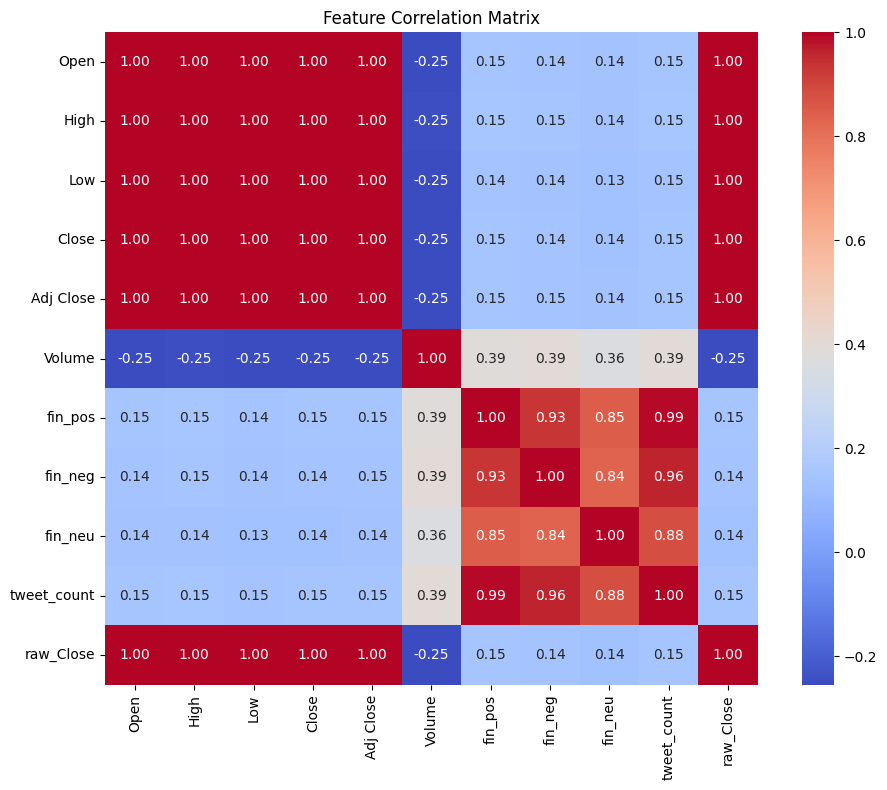

In [36]:
# Drop all non-numeric columns (like 'Stock', 'Date', etc.)
numeric_df = df.select_dtypes(include=[np.number])

# Then compute and plot the correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


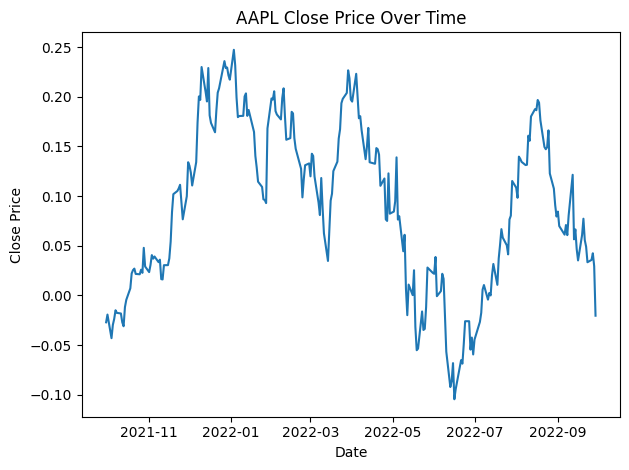

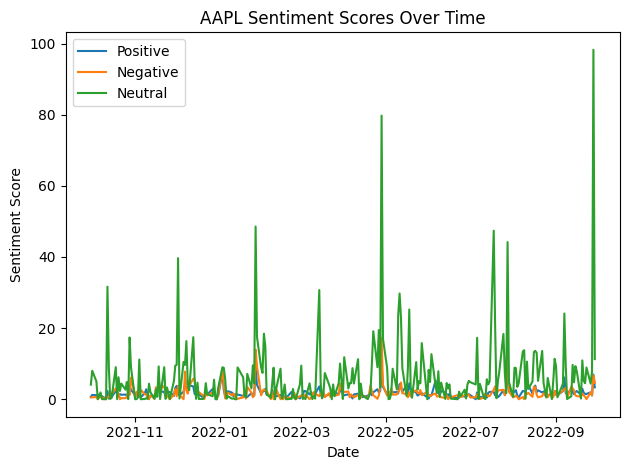

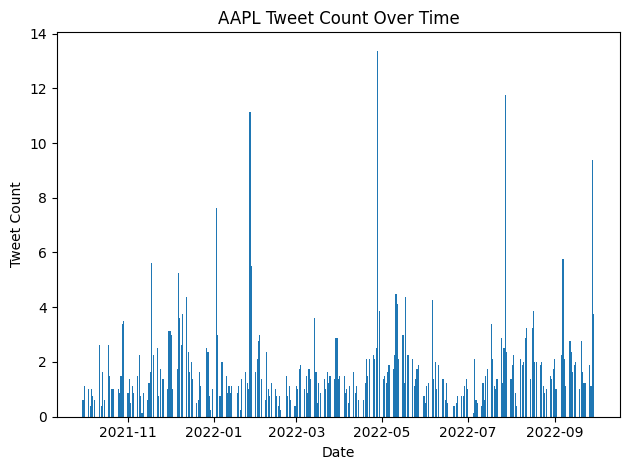

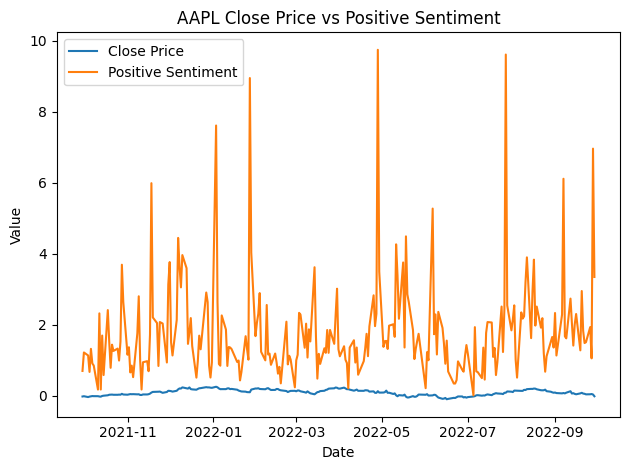

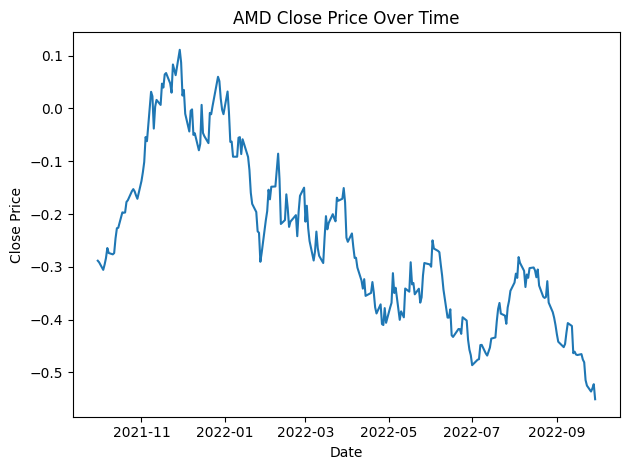

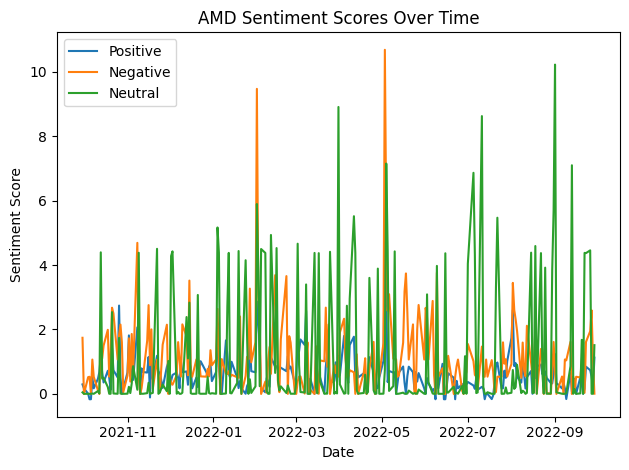

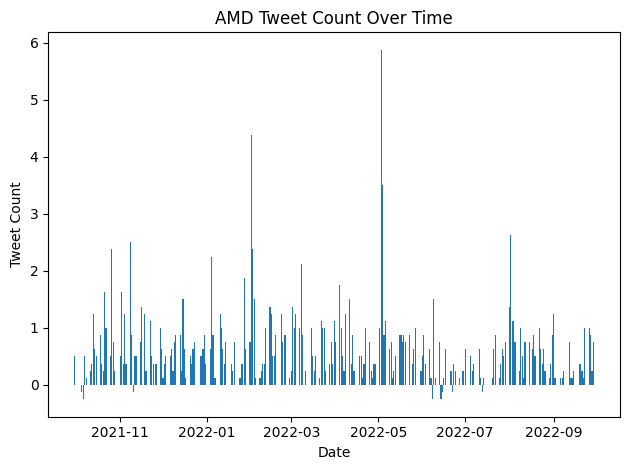

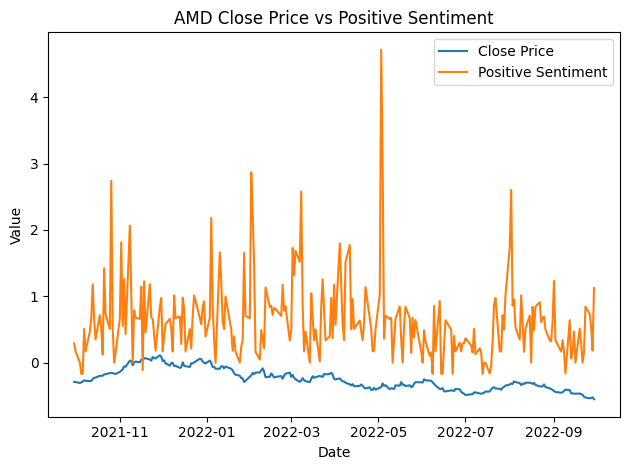

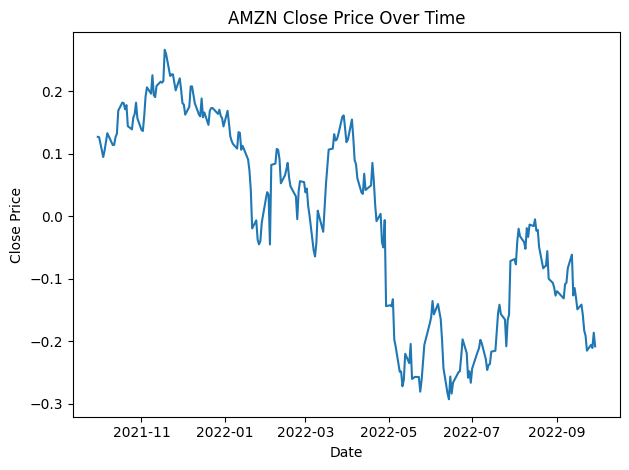

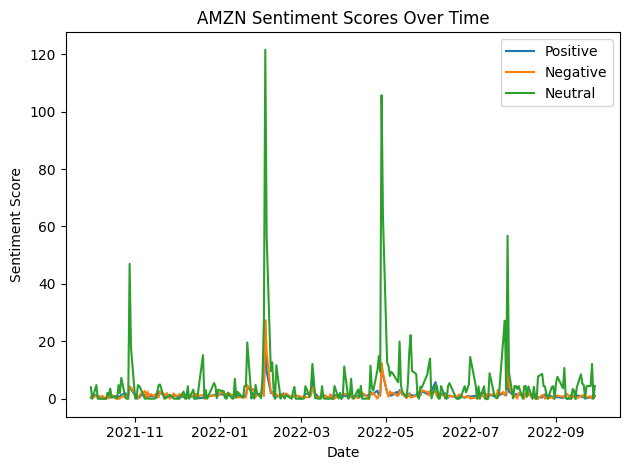

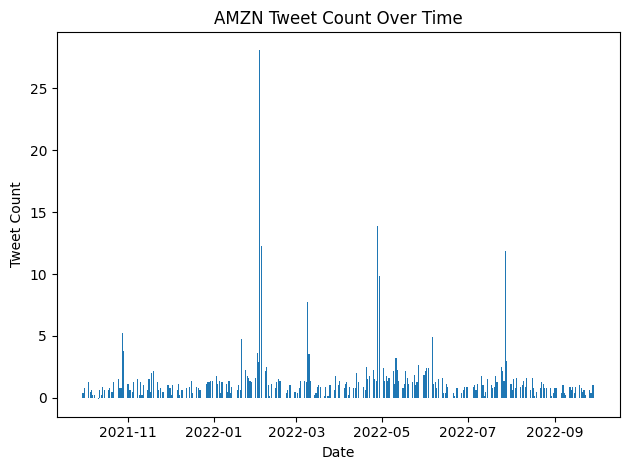

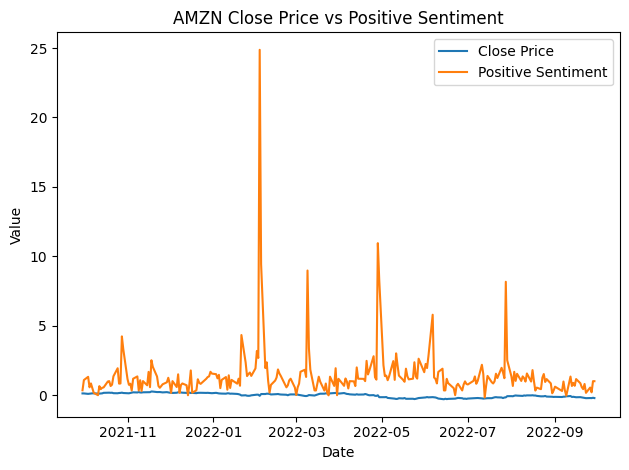

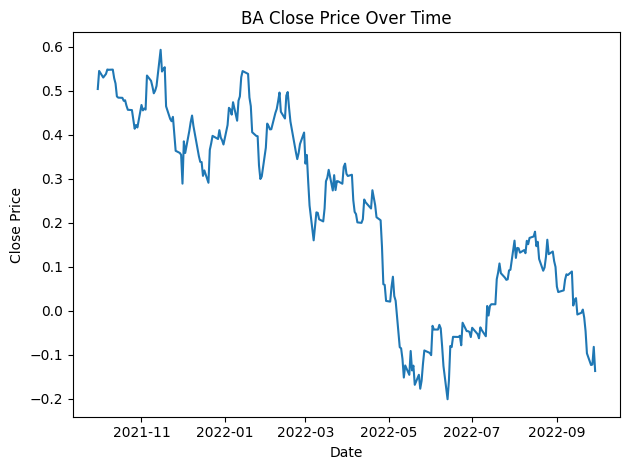

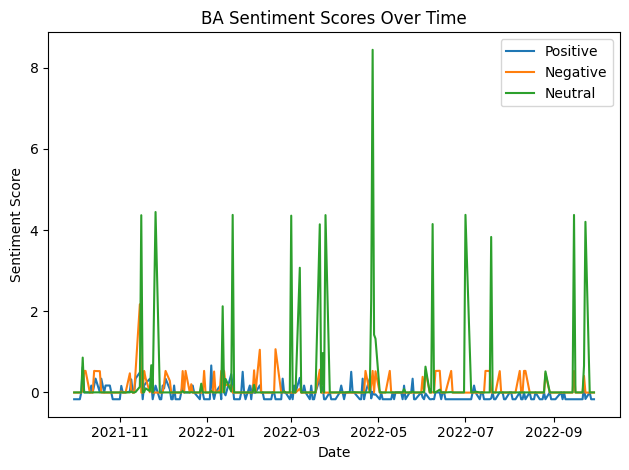

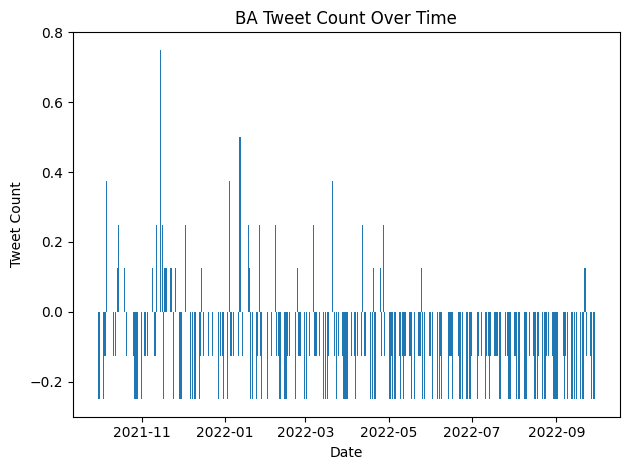

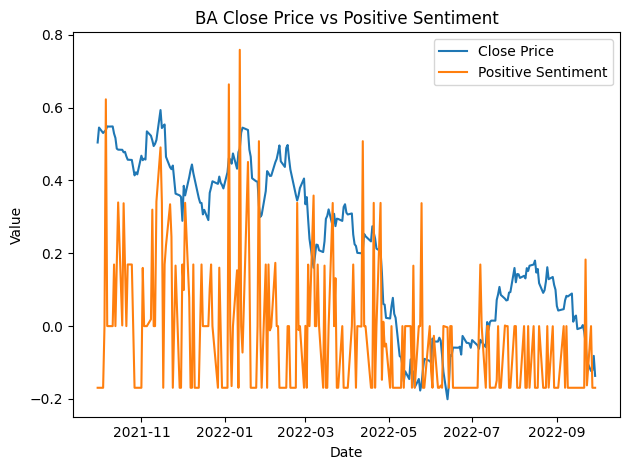

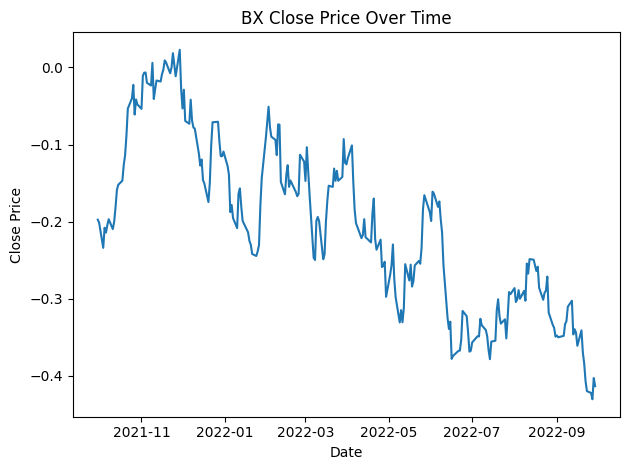

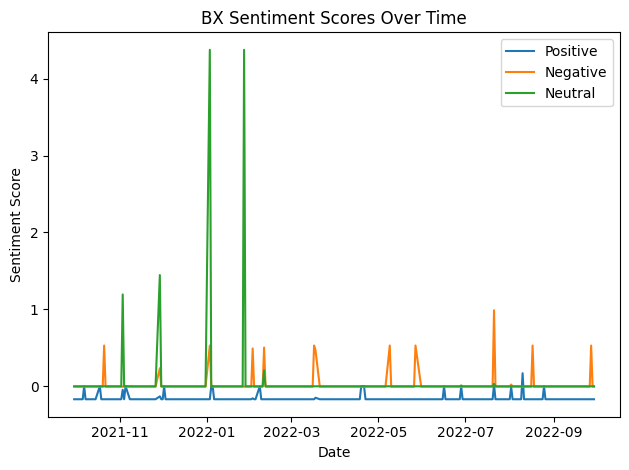

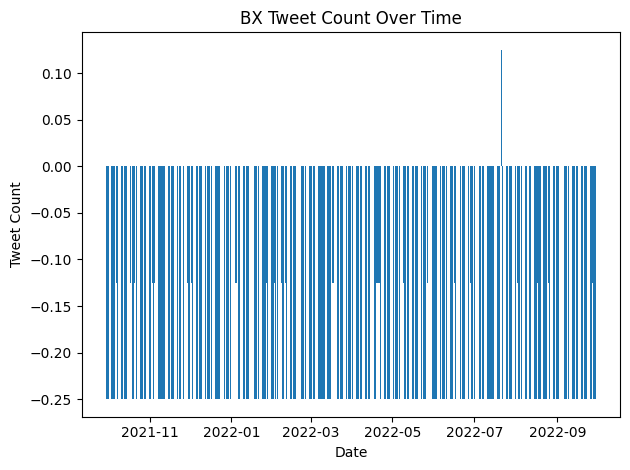

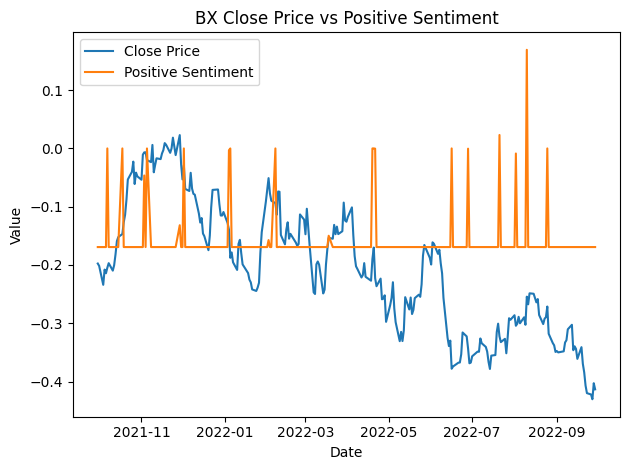

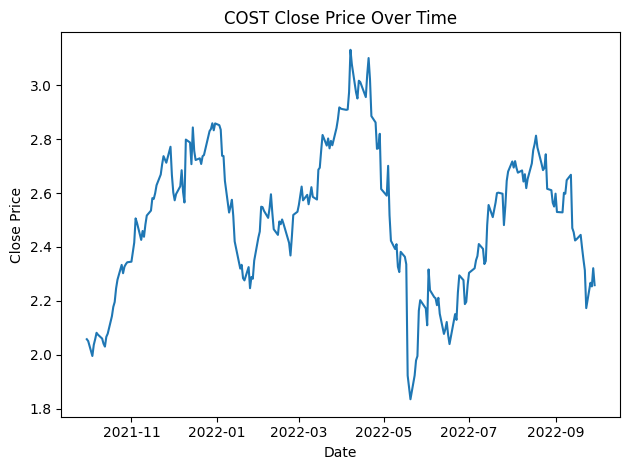

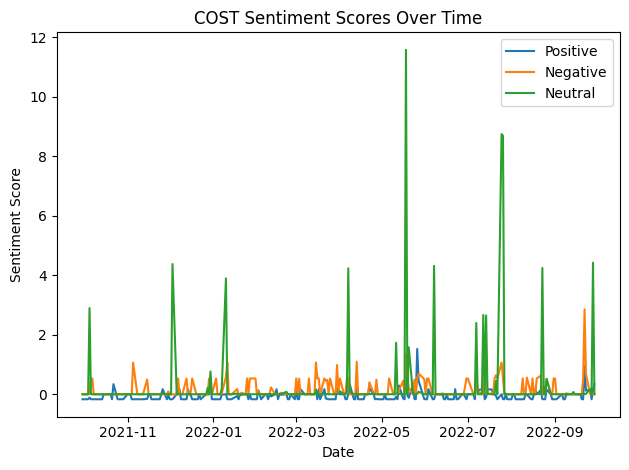

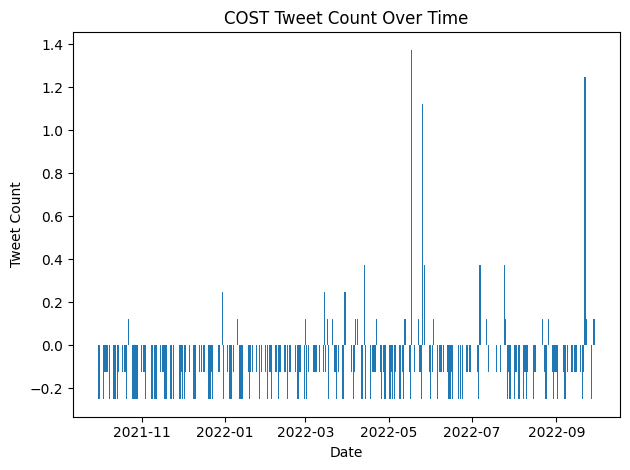

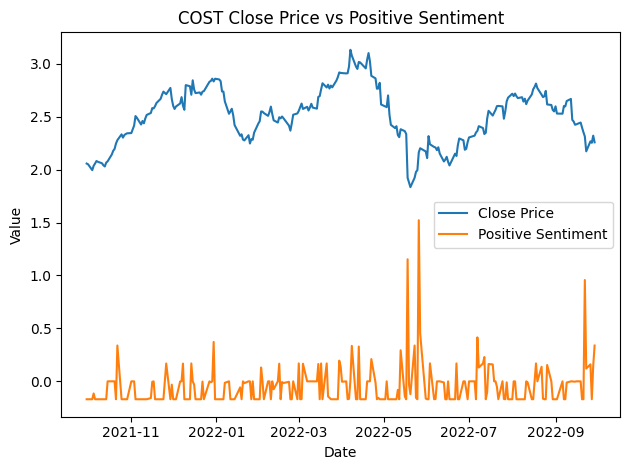

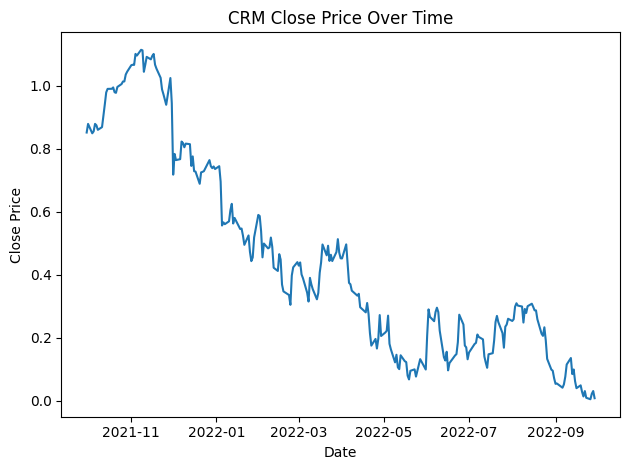

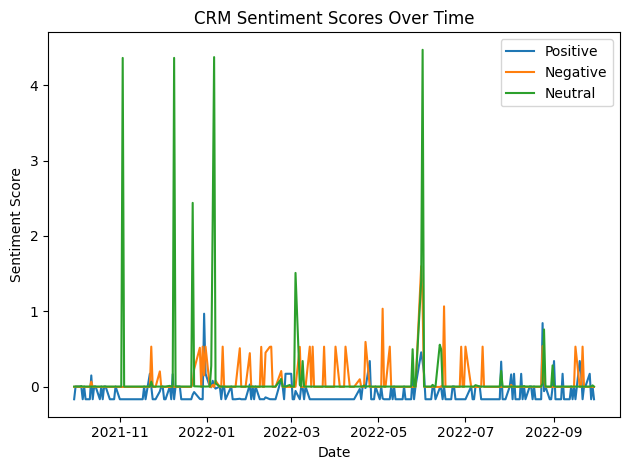

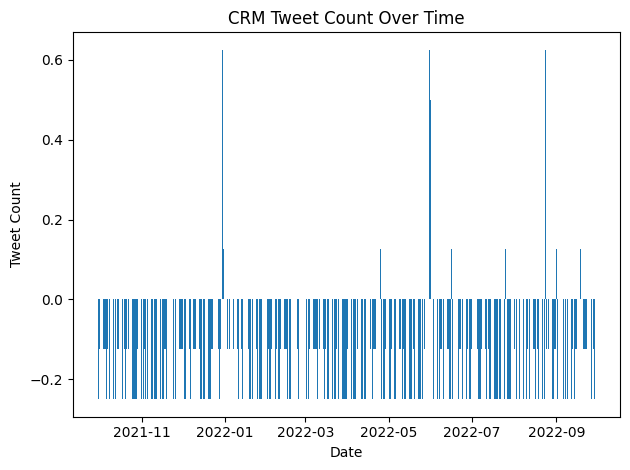

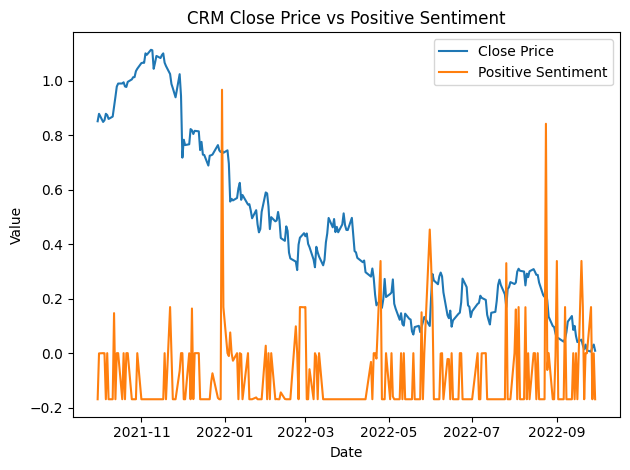

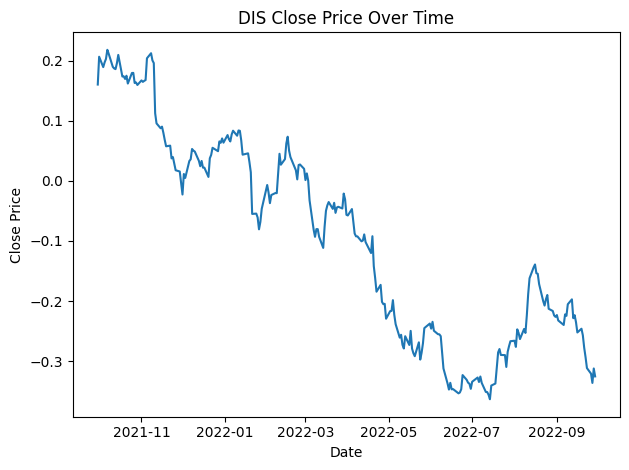

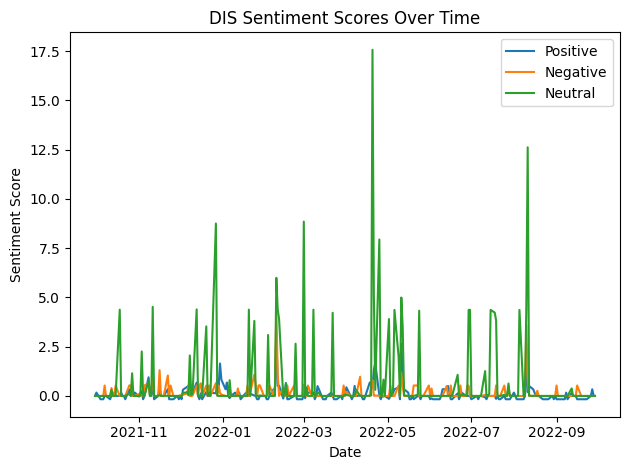

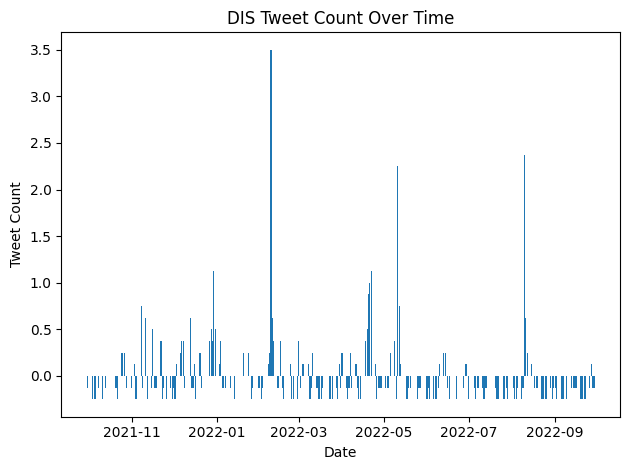

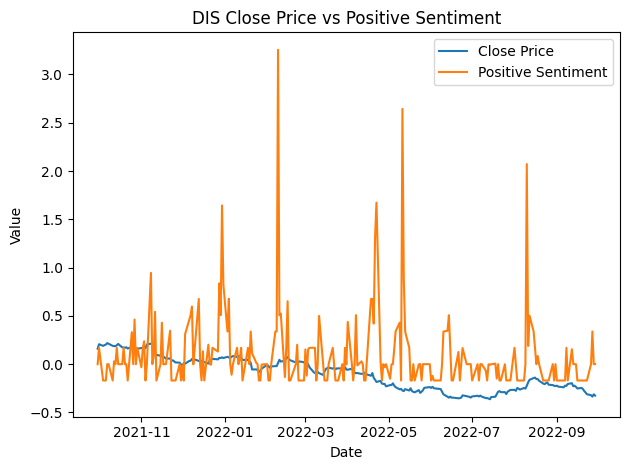

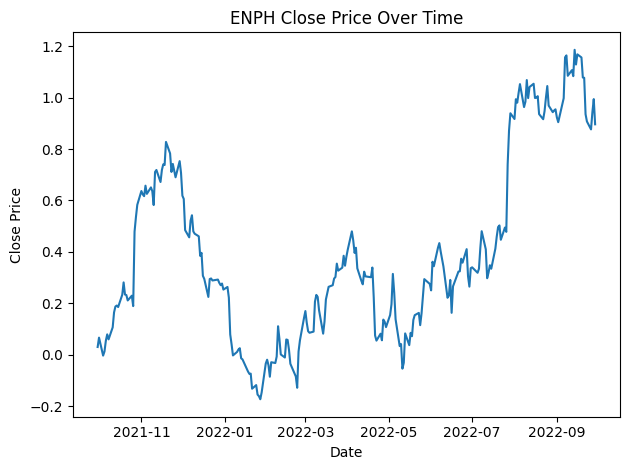

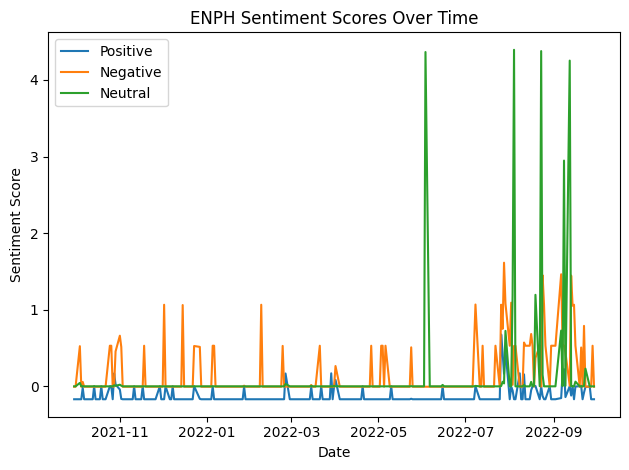

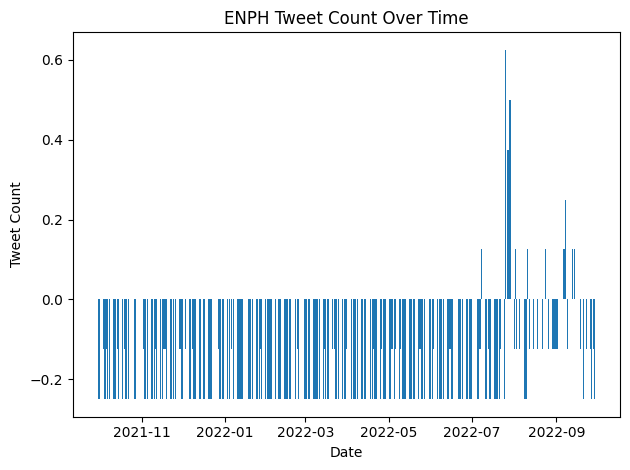

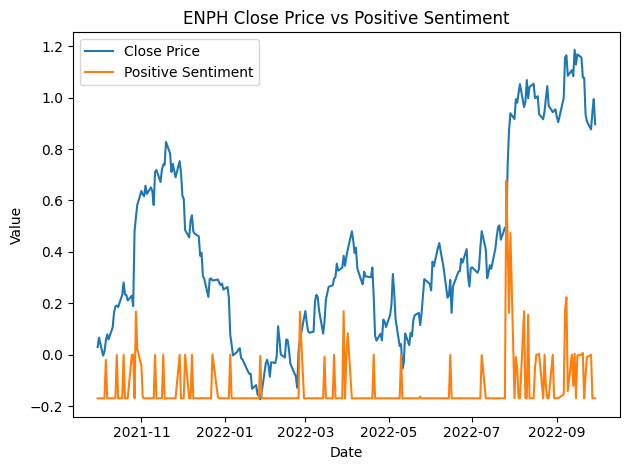

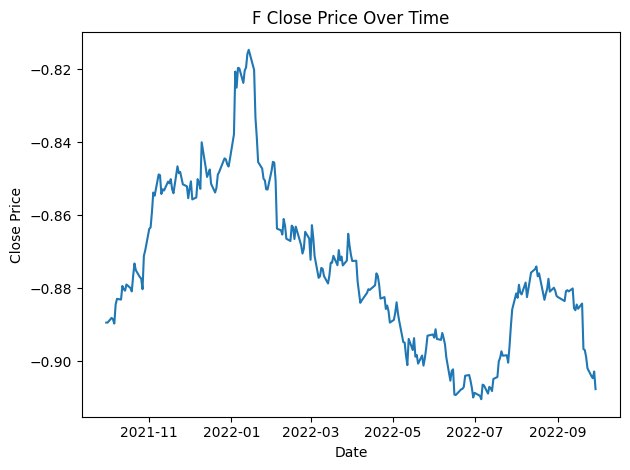

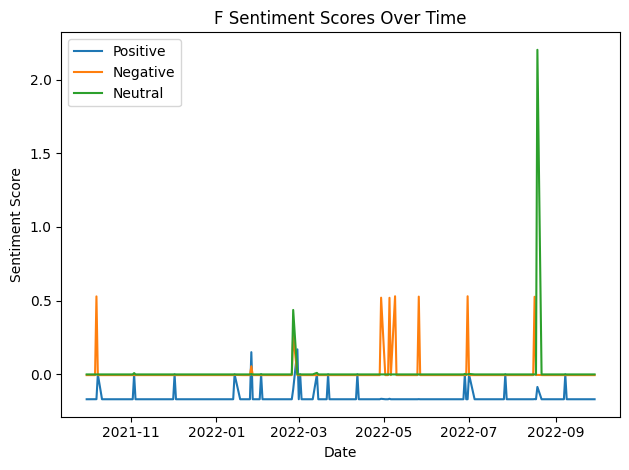

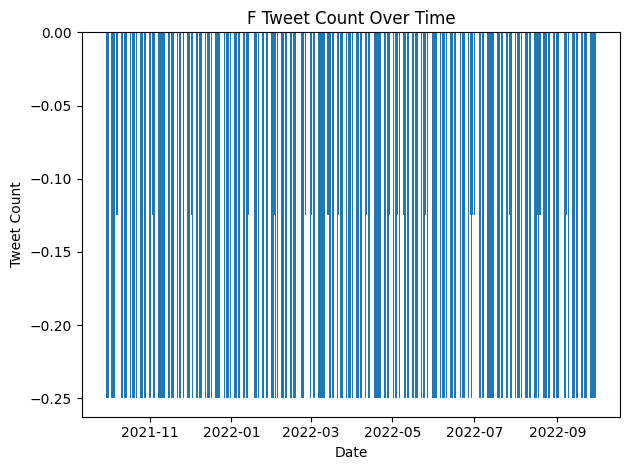

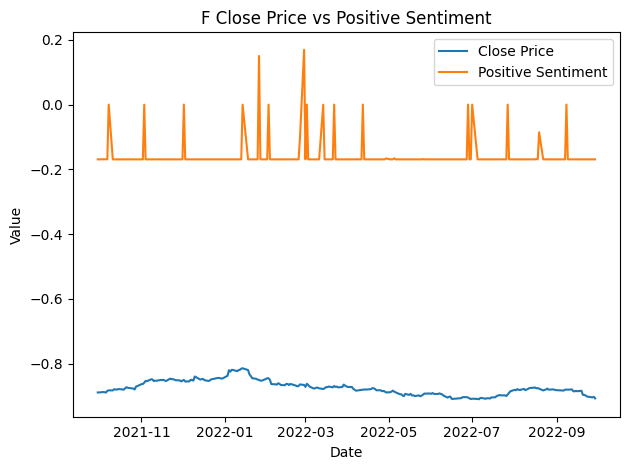

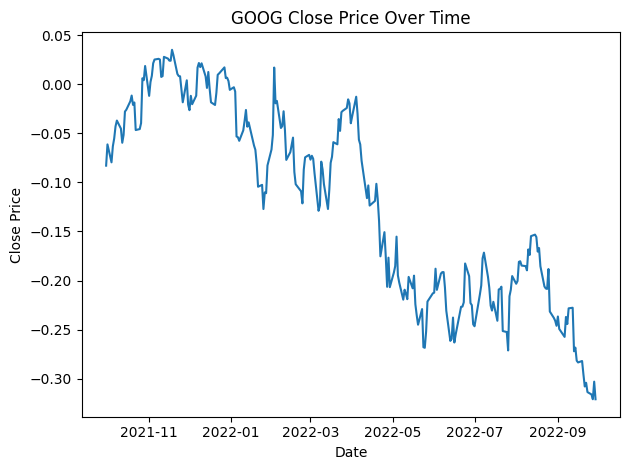

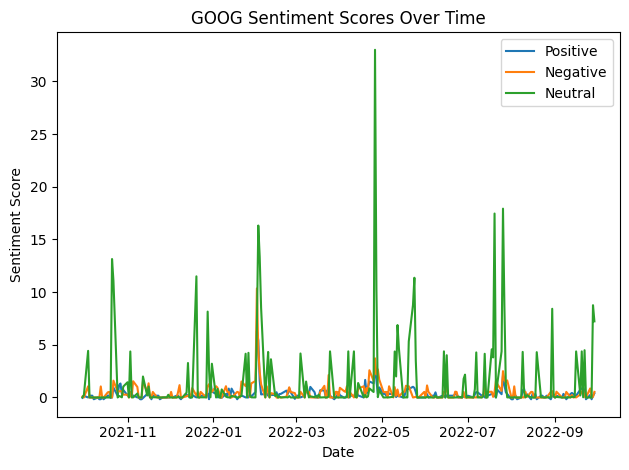

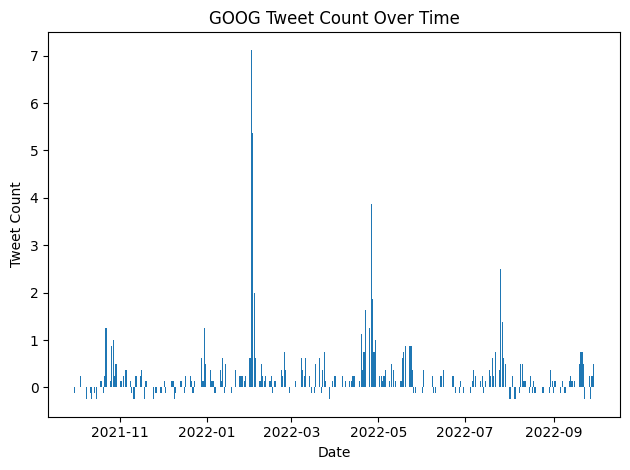

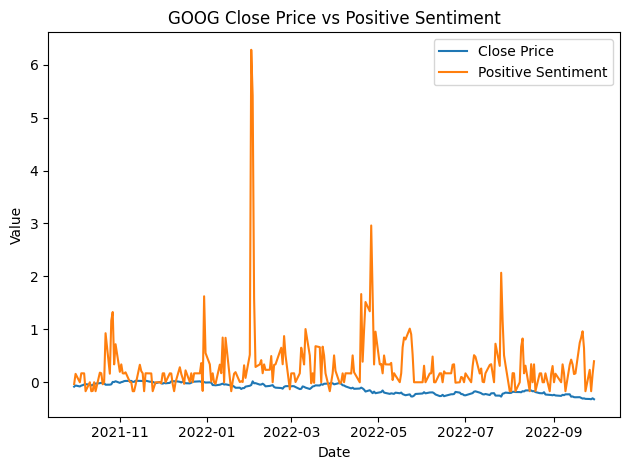

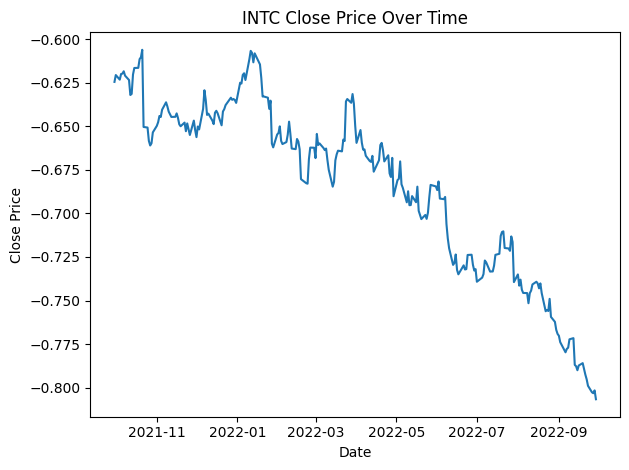

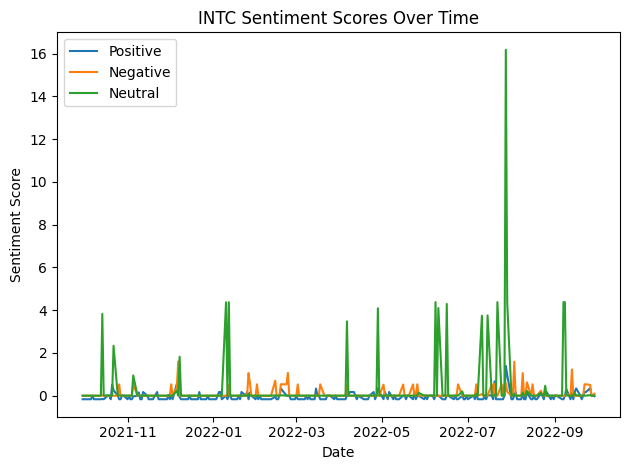

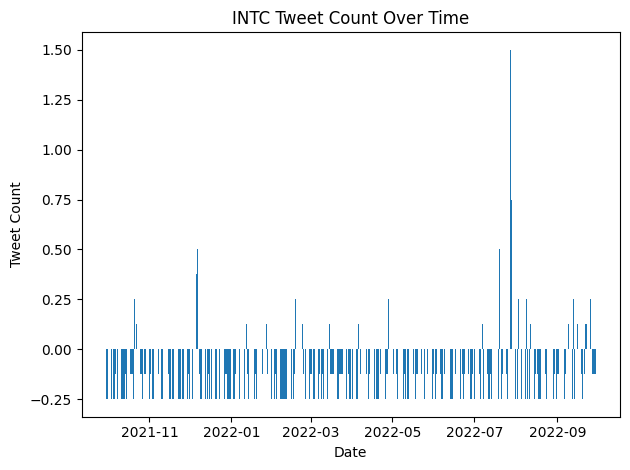

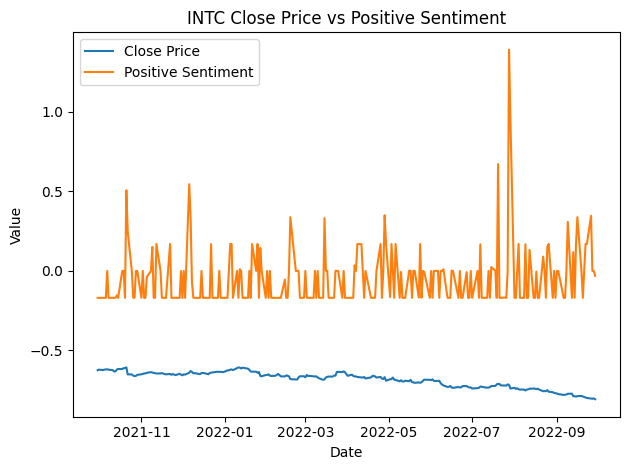

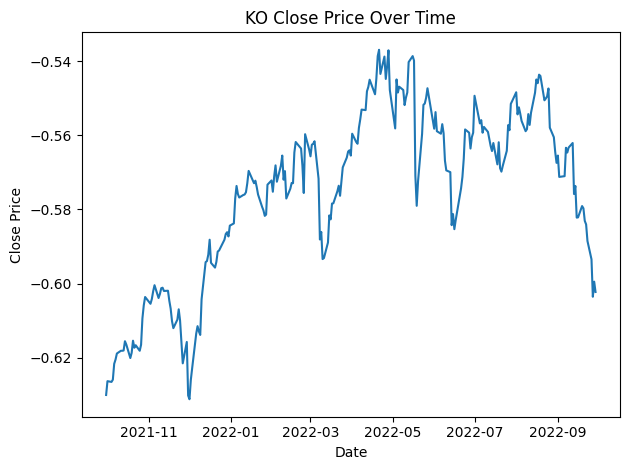

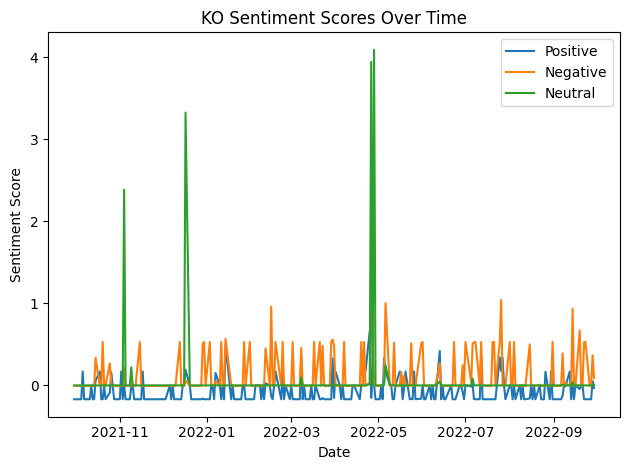

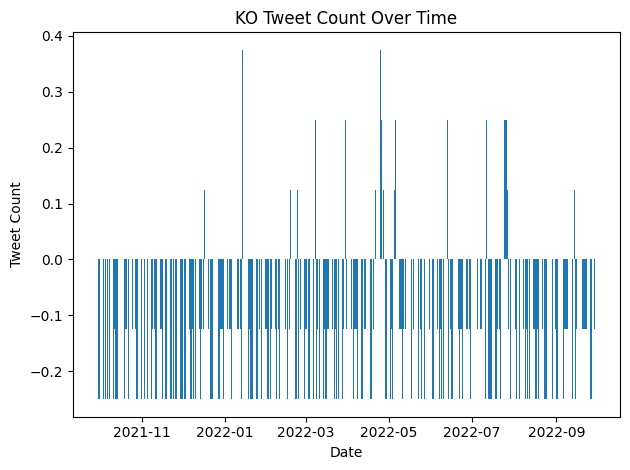

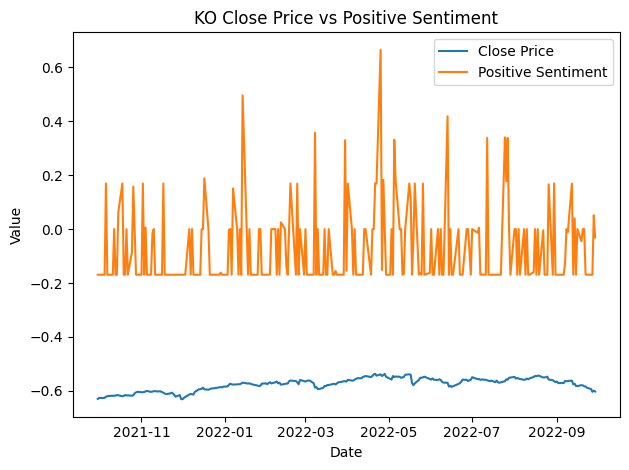

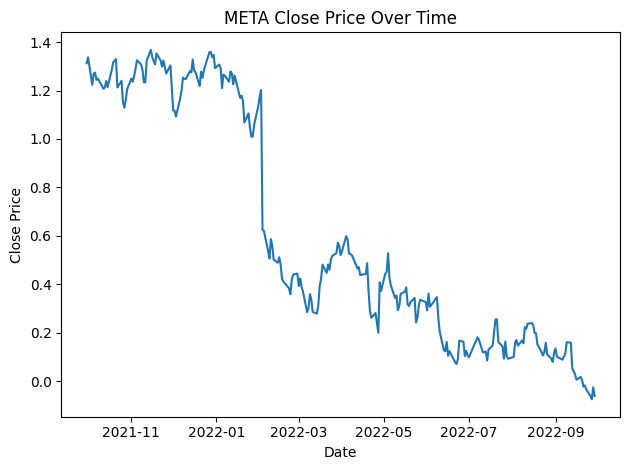

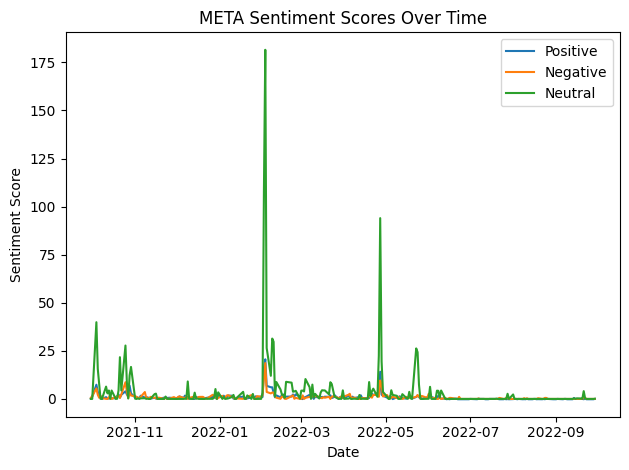

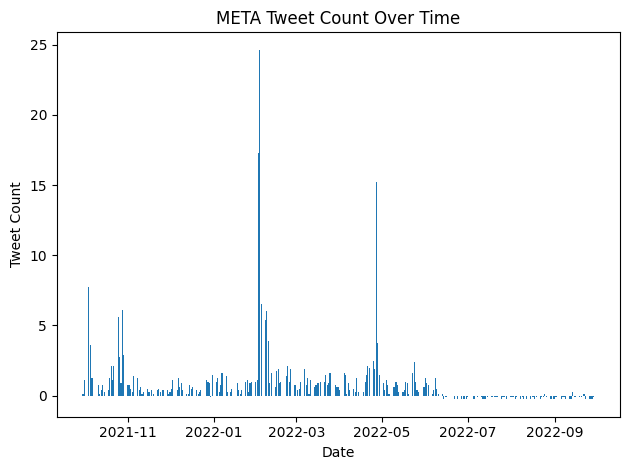

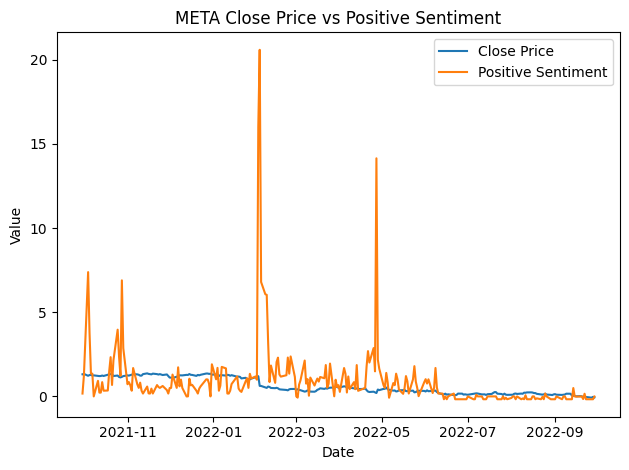

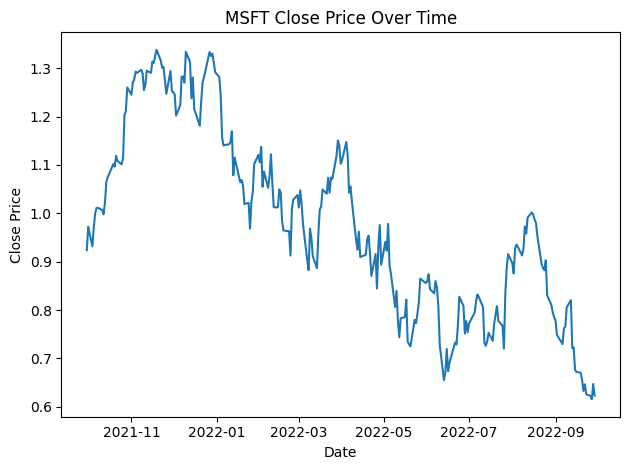

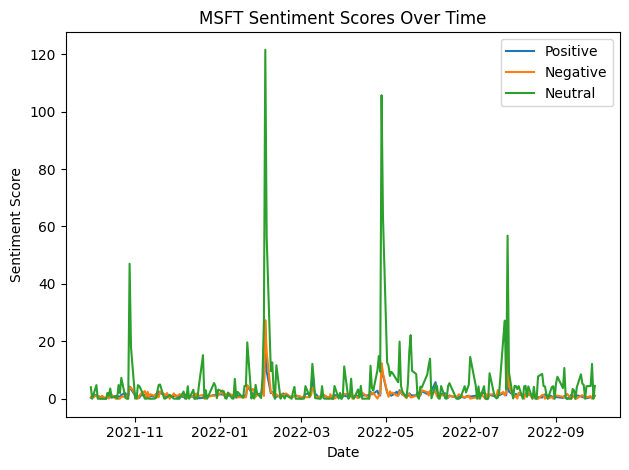

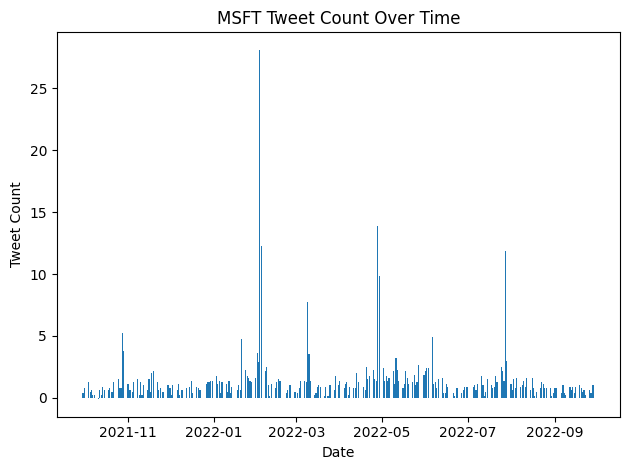

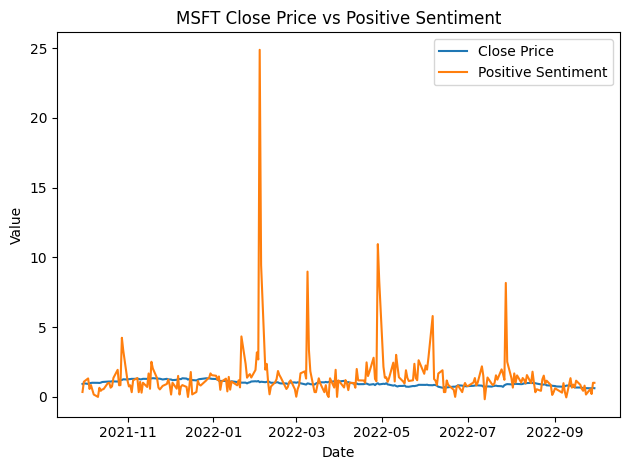

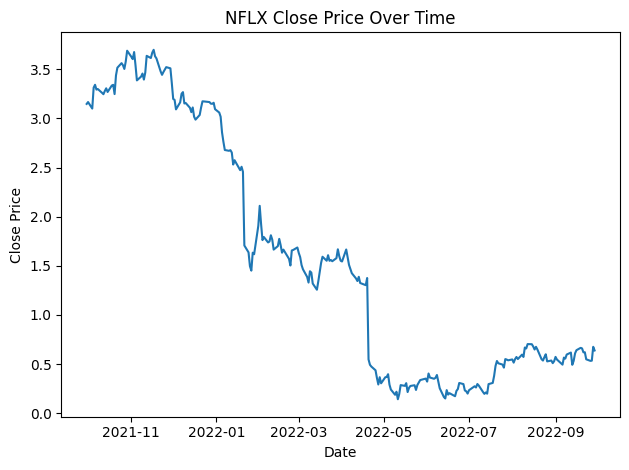

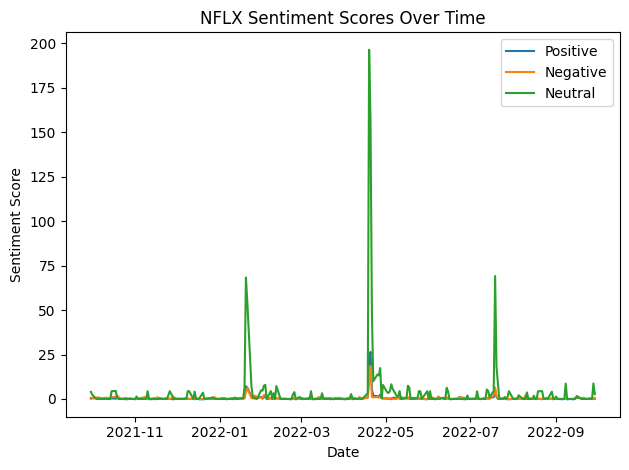

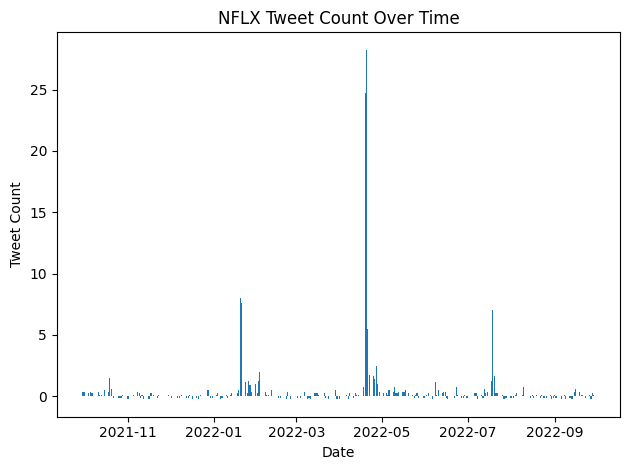

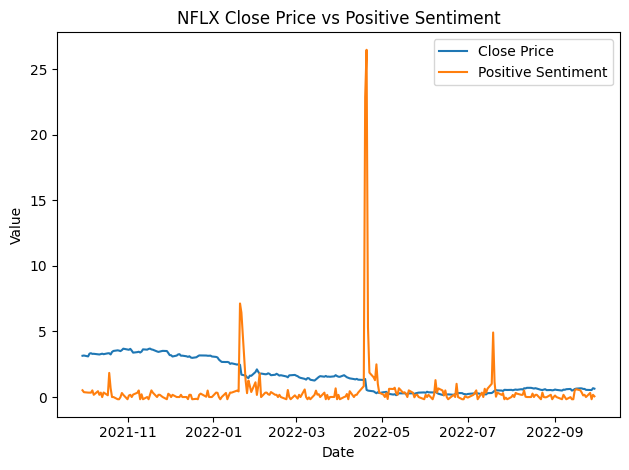

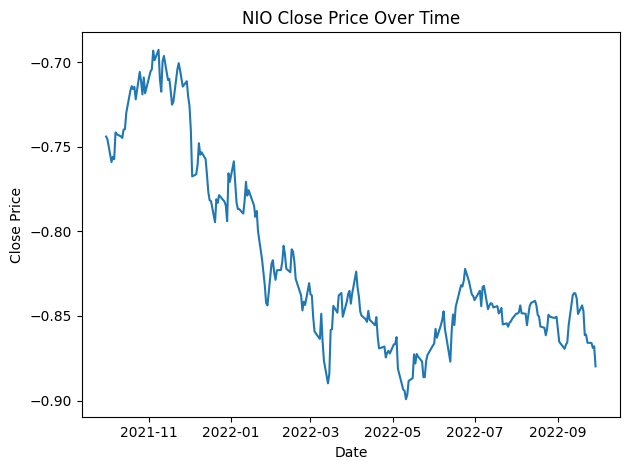

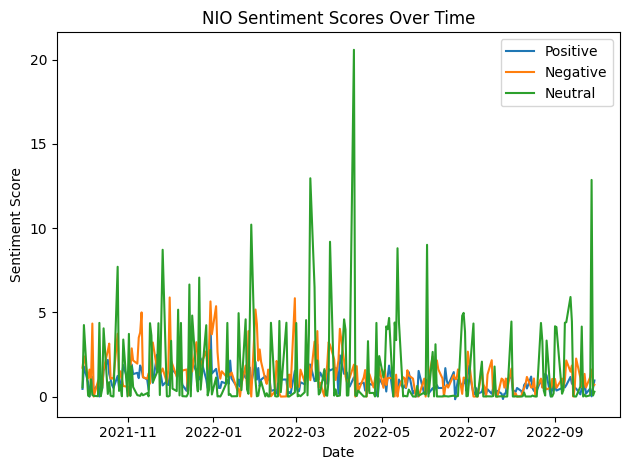

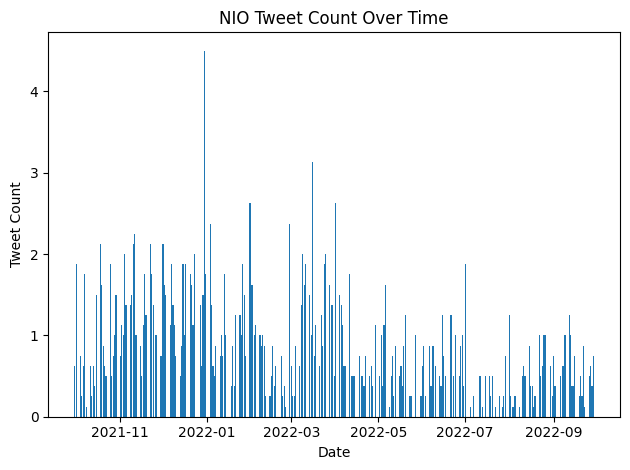

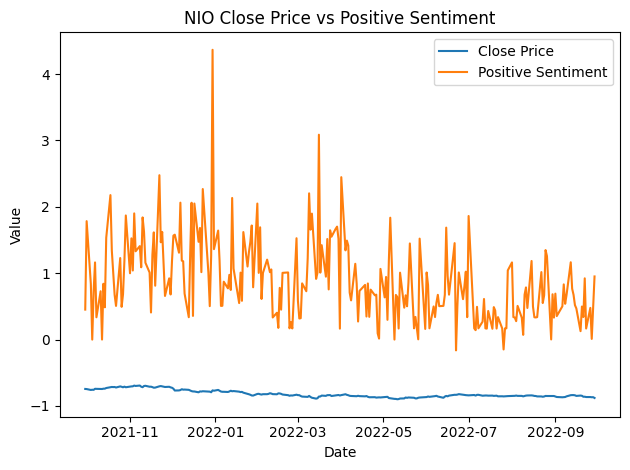

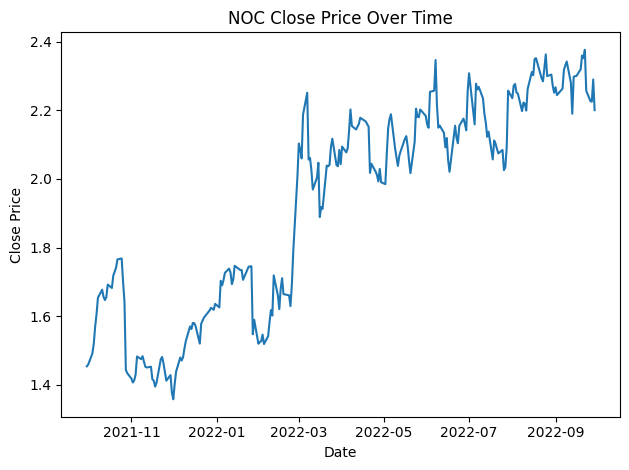

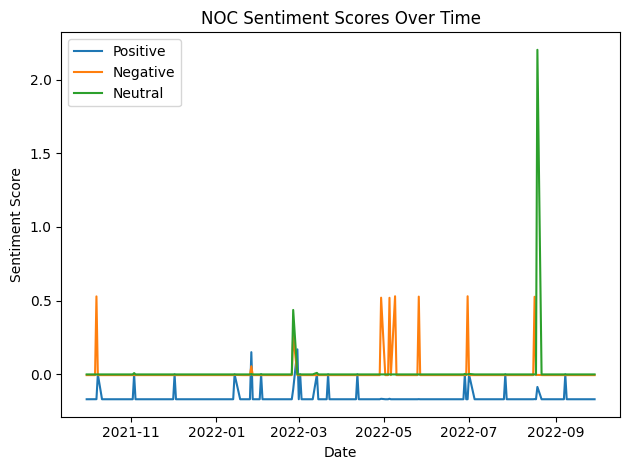

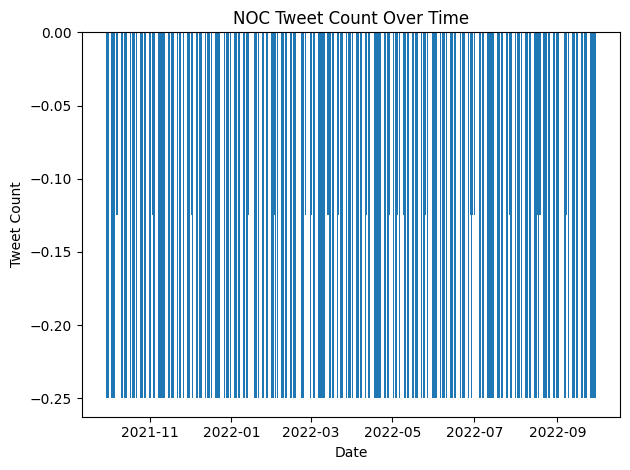

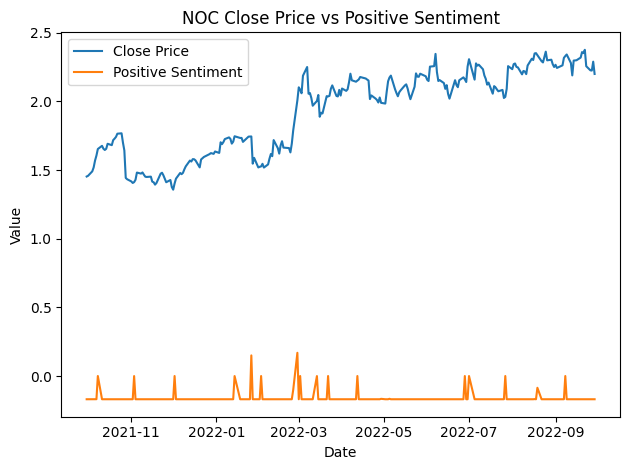

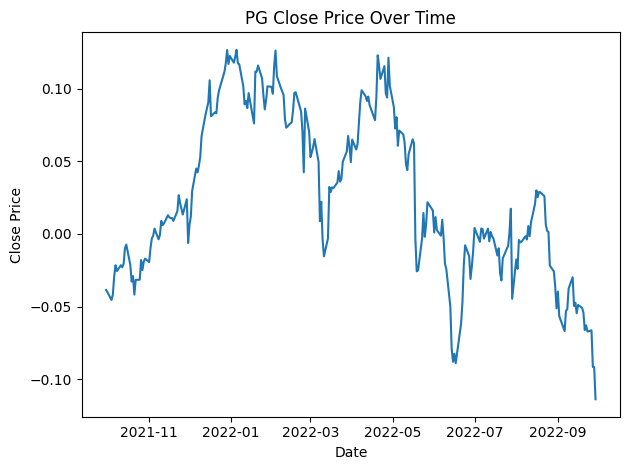

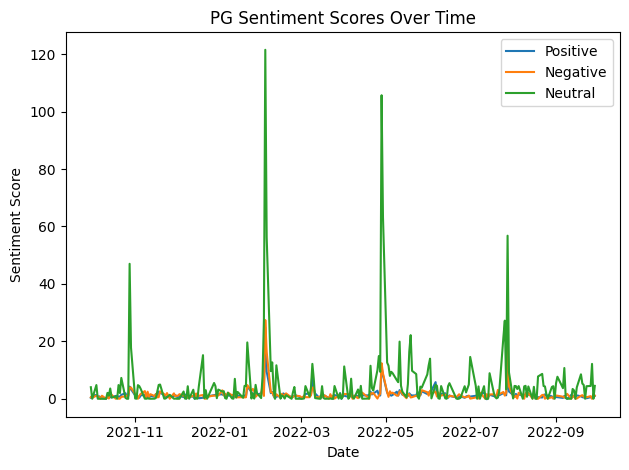

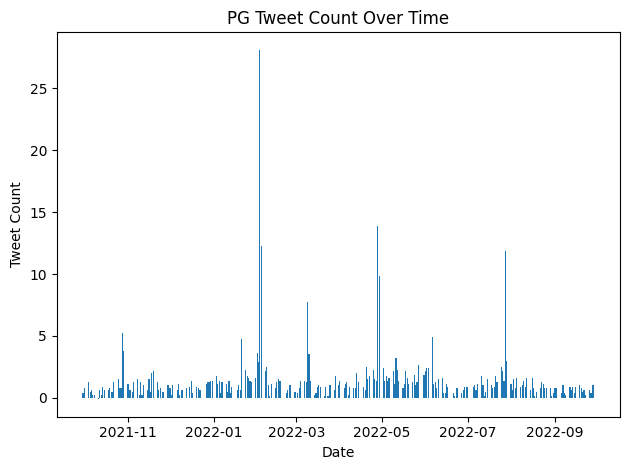

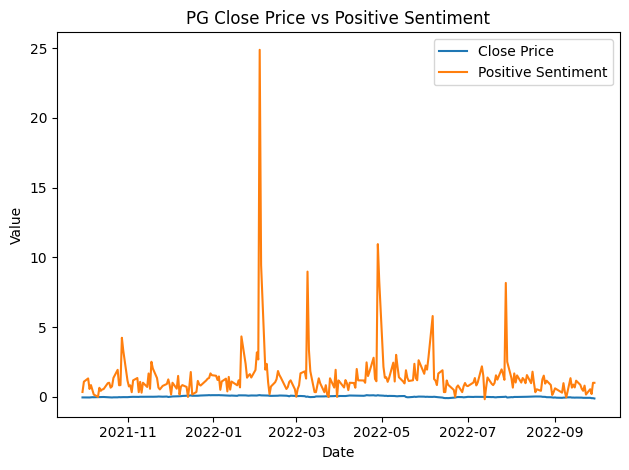

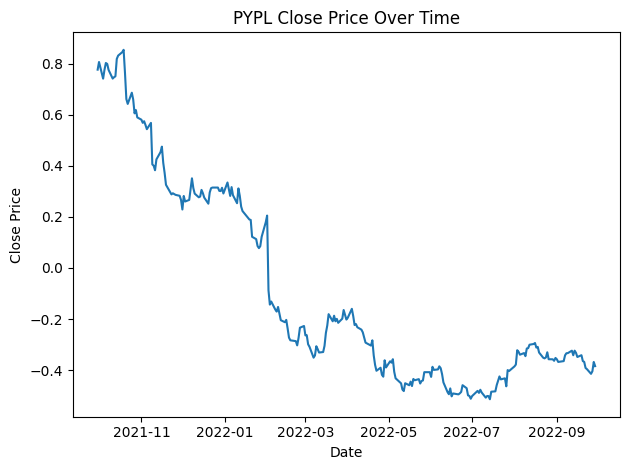

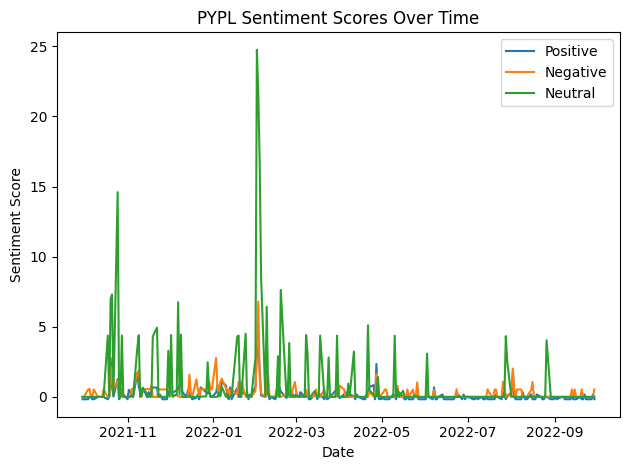

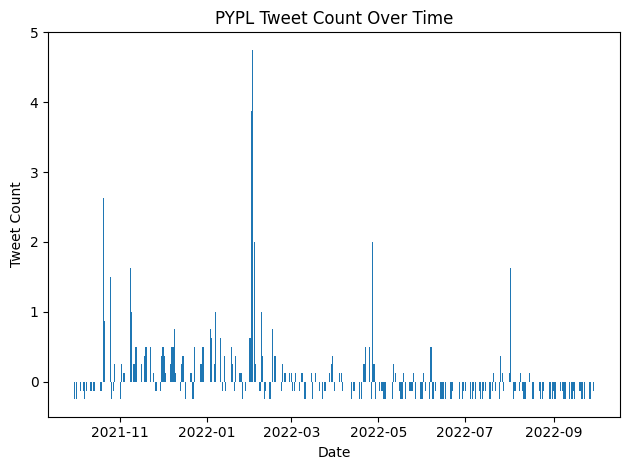

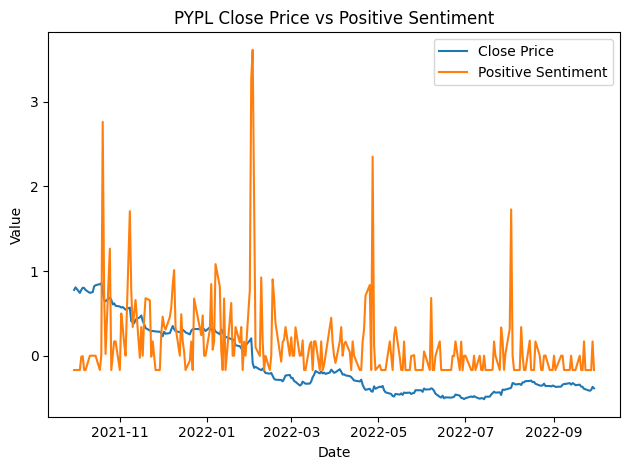

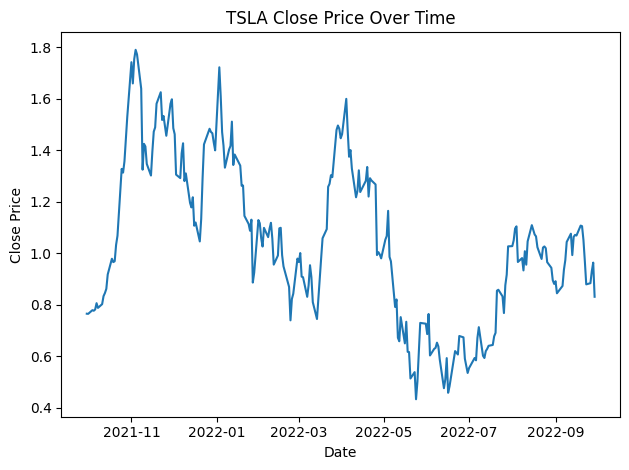

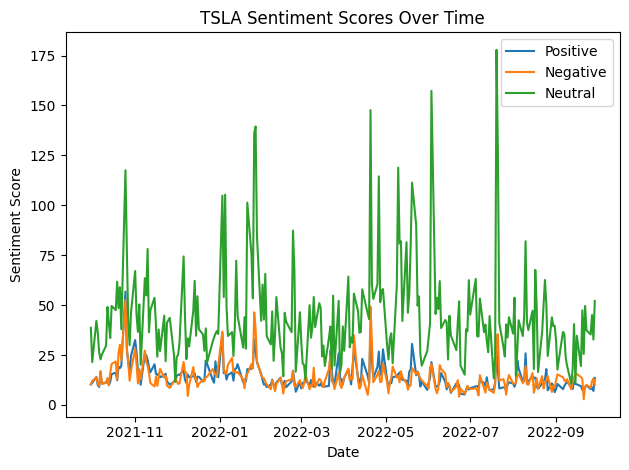

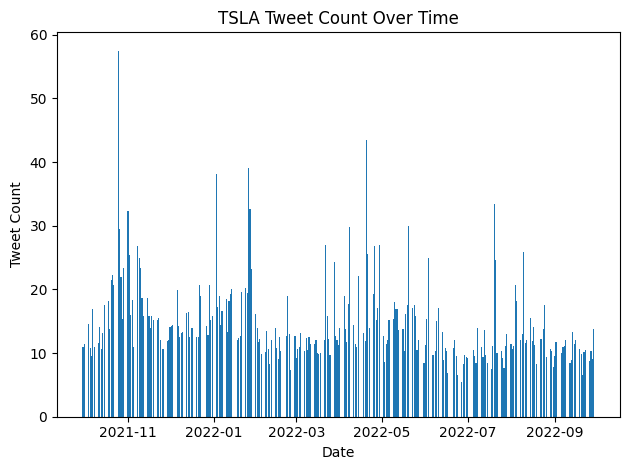

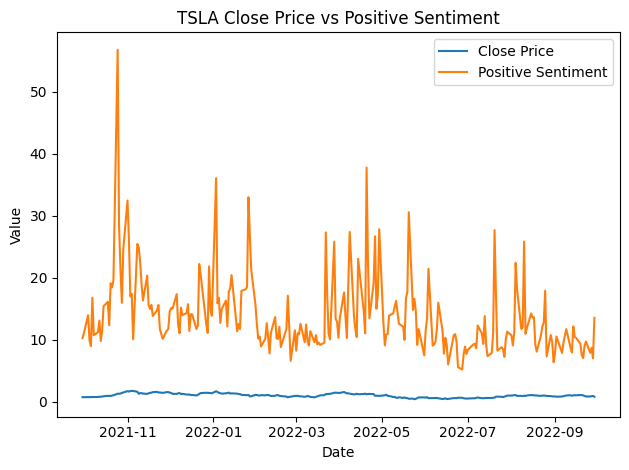

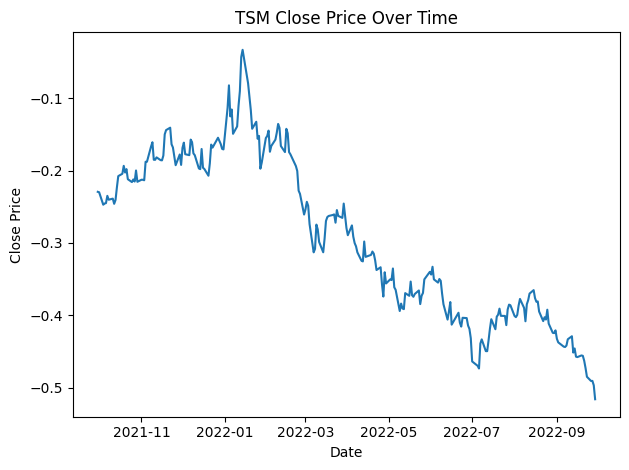

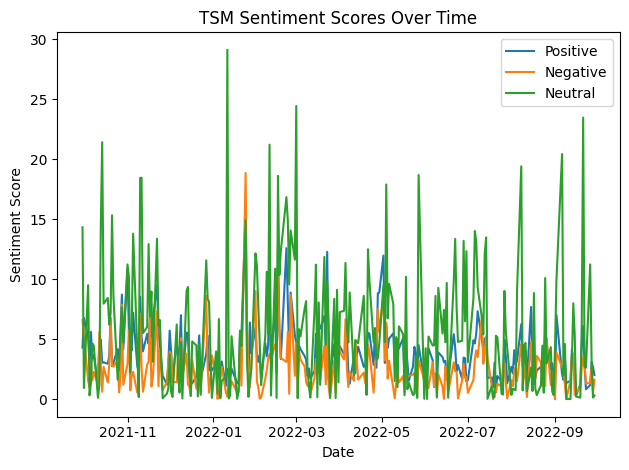

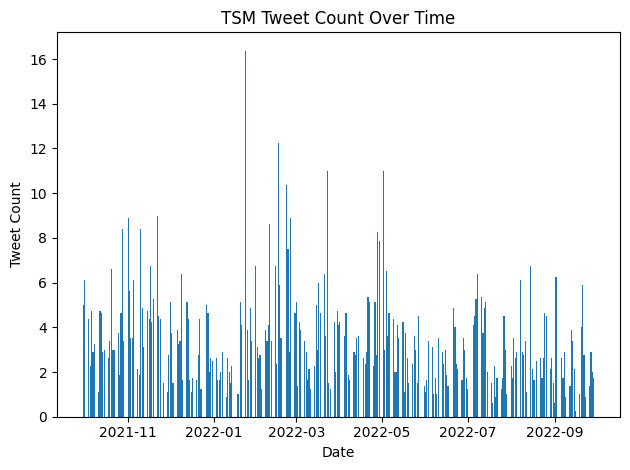

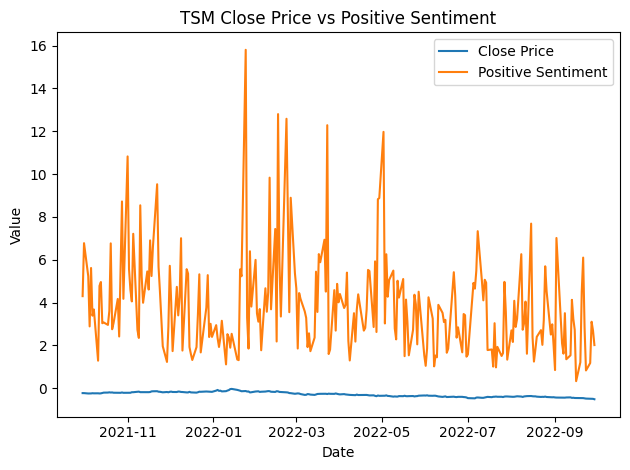

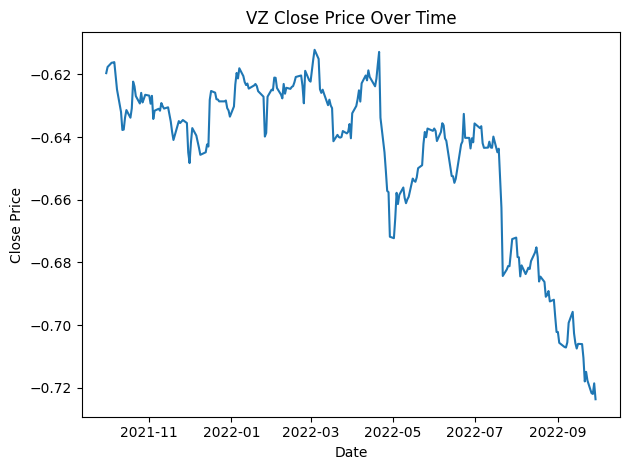

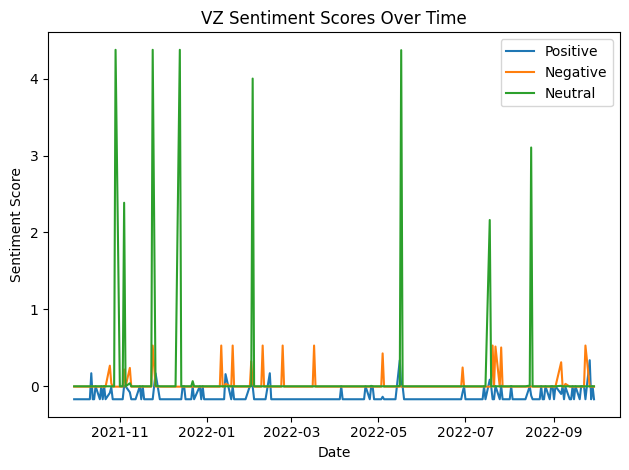

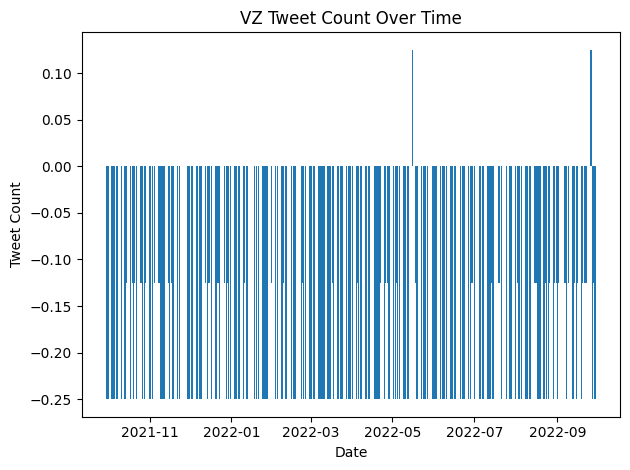

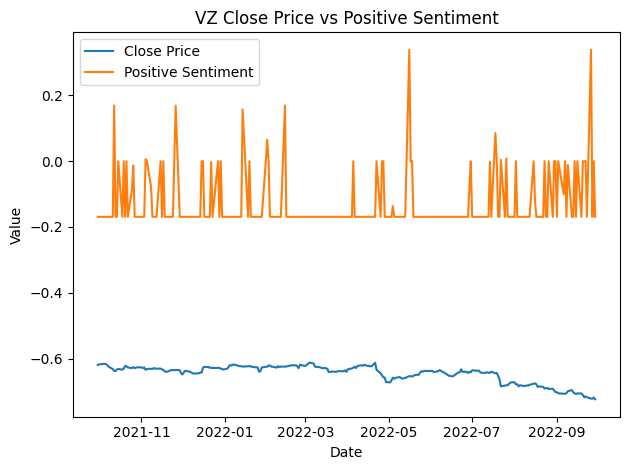

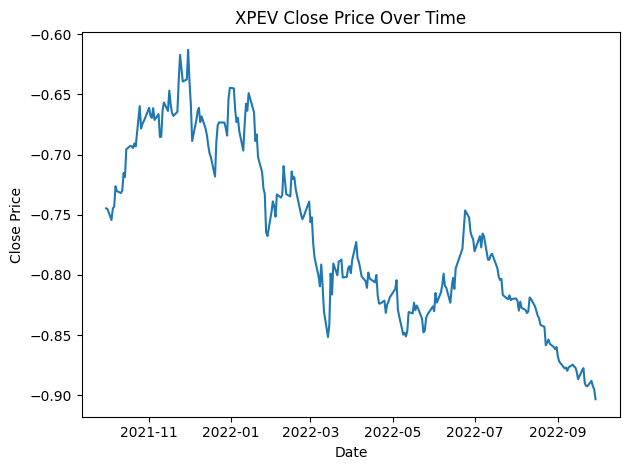

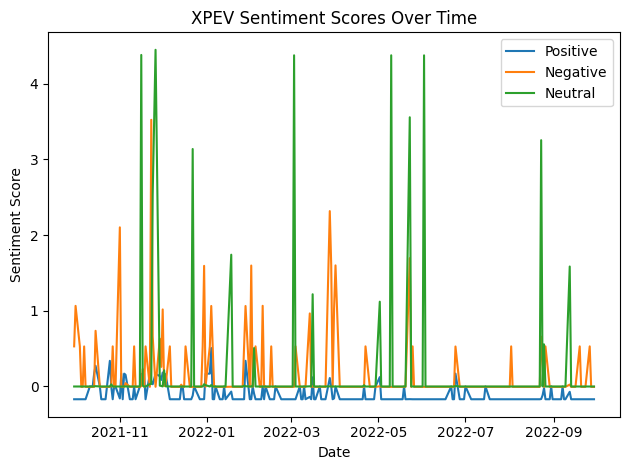

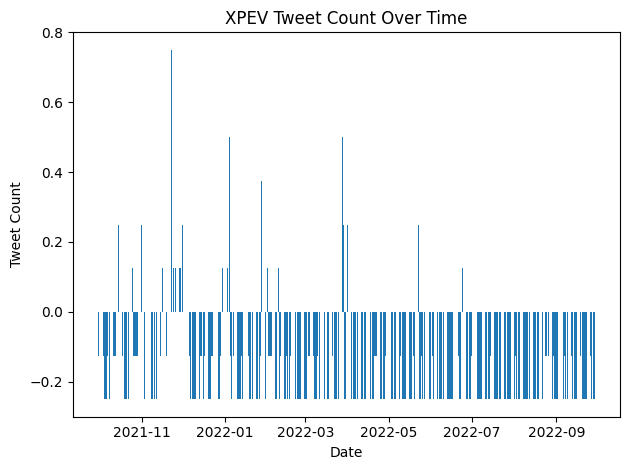

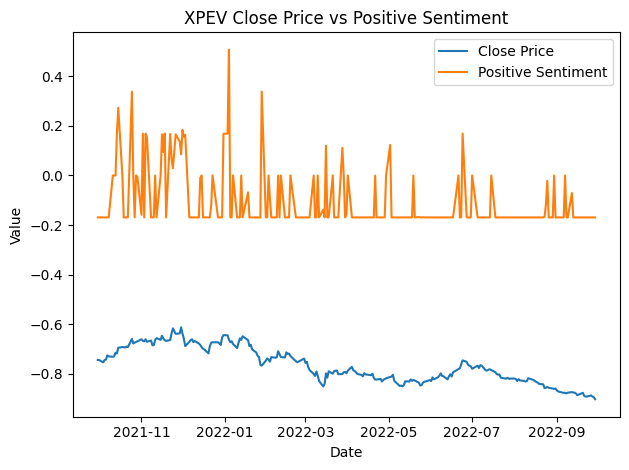

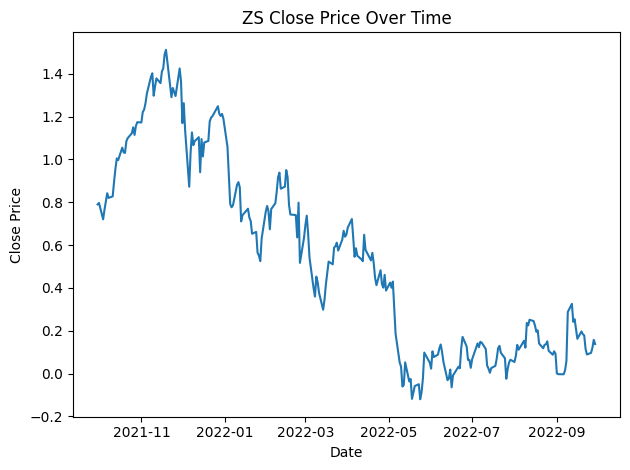

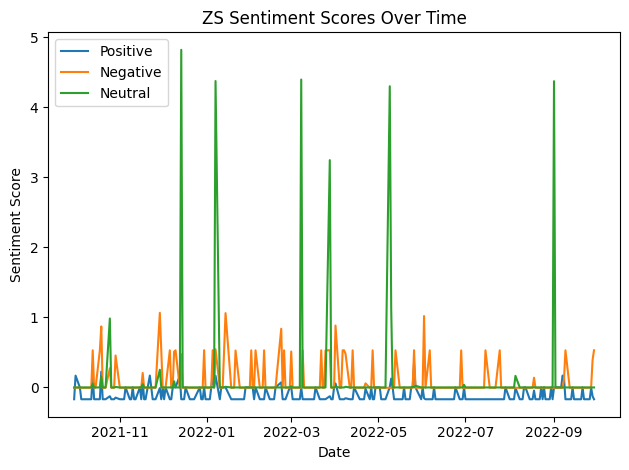

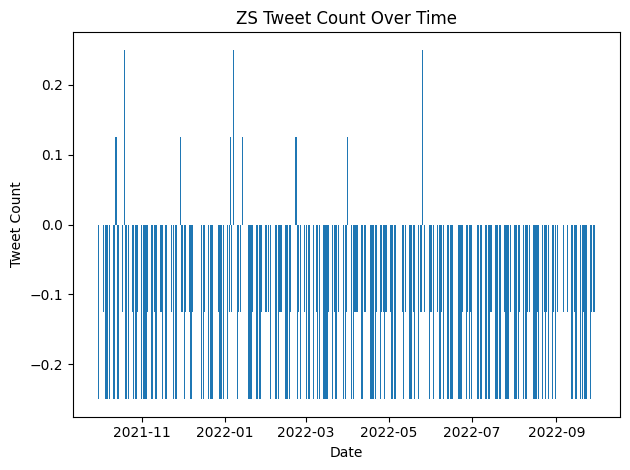

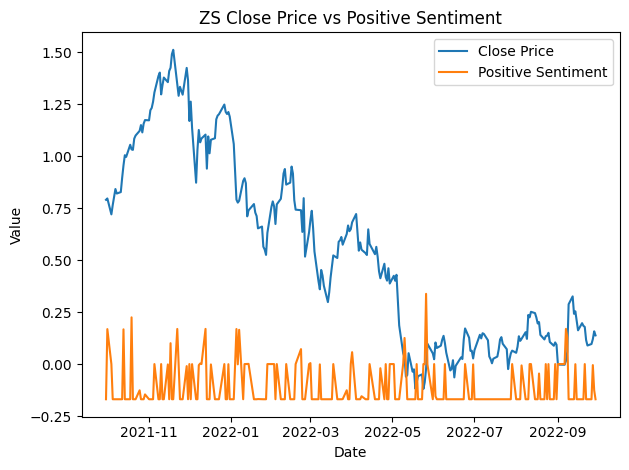

In [37]:
# Get list of stocks
stocks = df['Stock Name'].unique()

for stock in stocks:
    sub = df[df['Stock Name'] == stock].sort_values('Date')

    # 1. Close Price Over Time
    plt.figure()
    plt.plot(sub['Date'], sub['Close'])
    plt.title(f'{stock} Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.tight_layout()
    plt.show()

    # 2. Sentiment Scores Over Time
    plt.figure()
    plt.plot(sub['Date'], sub['fin_pos'], label='Positive')
    plt.plot(sub['Date'], sub['fin_neg'], label='Negative')
    plt.plot(sub['Date'], sub['fin_neu'], label='Neutral')
    plt.title(f'{stock} Sentiment Scores Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Tweet Count Over Time
    plt.figure()
    plt.bar(sub['Date'], sub['tweet_count'])
    plt.title(f'{stock} Tweet Count Over Time')
    plt.xlabel('Date')
    plt.ylabel('Tweet Count')
    plt.tight_layout()
    plt.show()

    # 4. Combined: Close Price vs Positive Sentiment
    plt.figure()
    plt.plot(sub['Date'], sub['Close'], label='Close Price')
    plt.plot(sub['Date'], sub['fin_pos'], label='Positive Sentiment')
    plt.title(f'{stock} Close Price vs Positive Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()









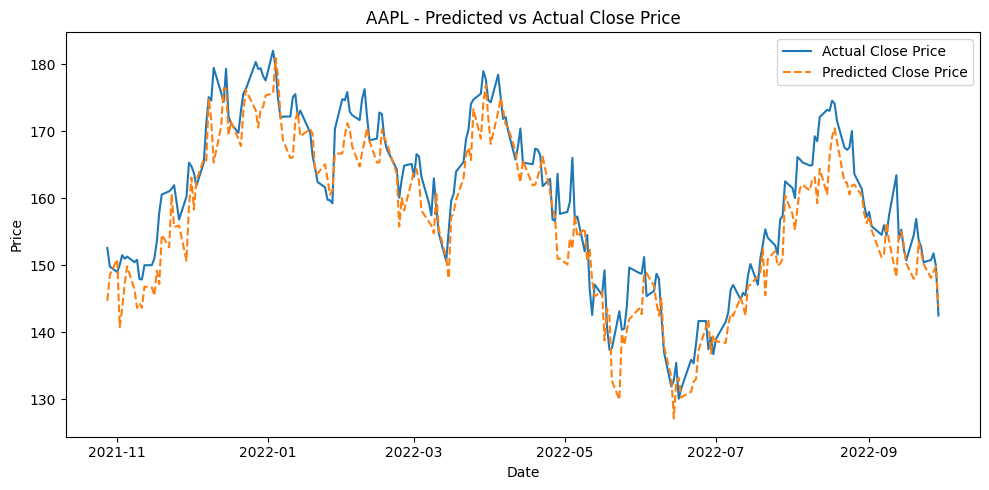

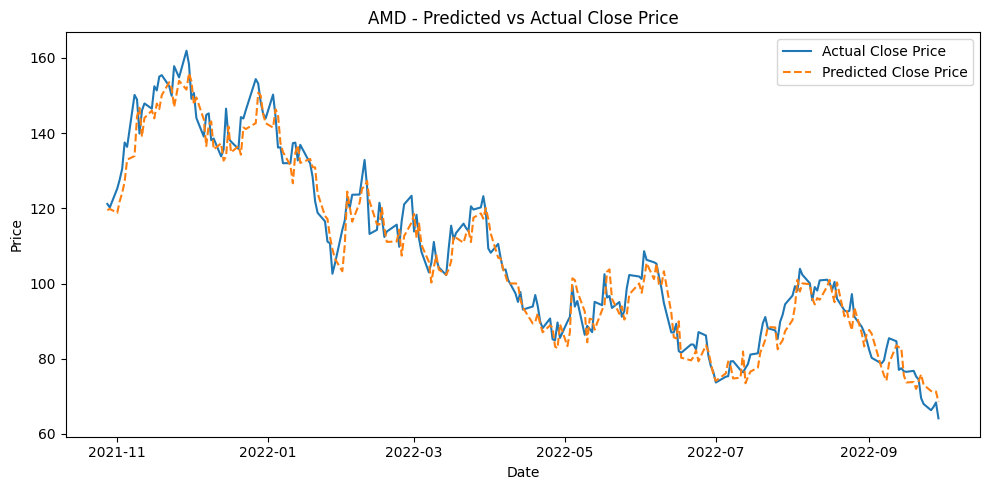

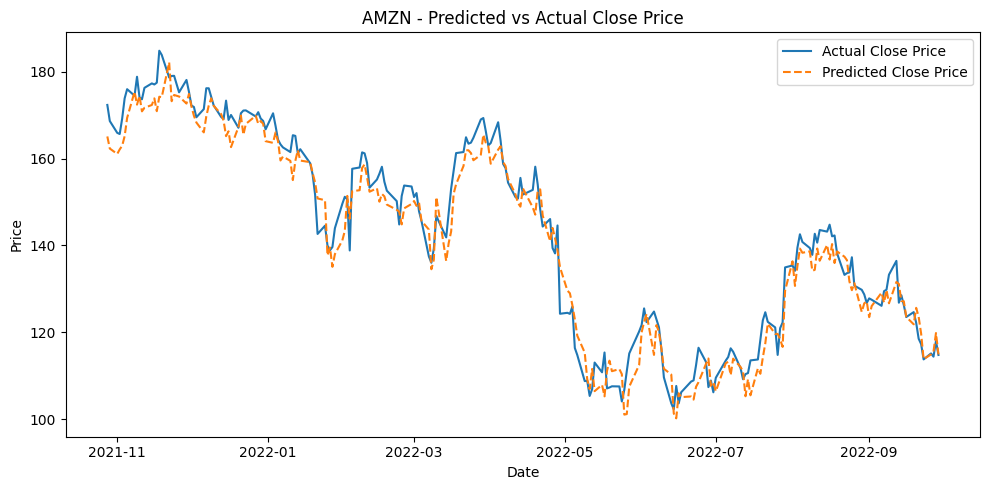

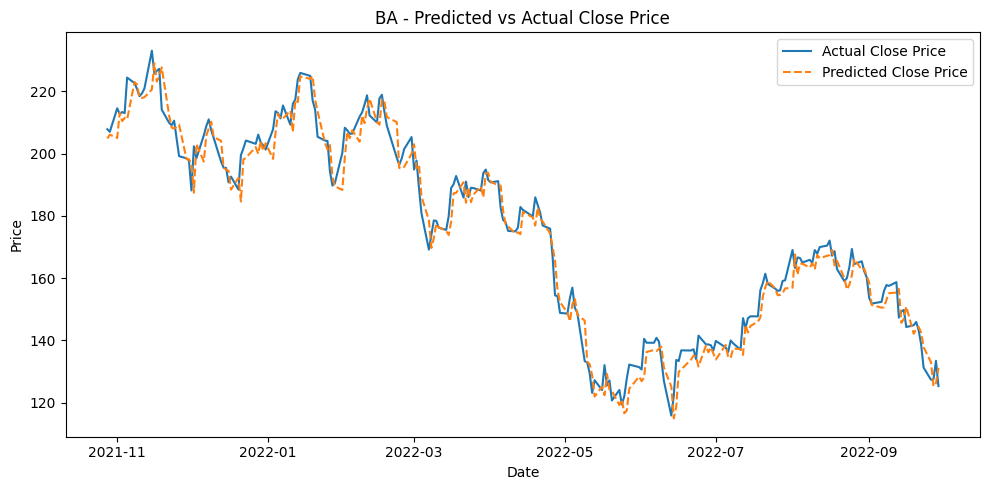

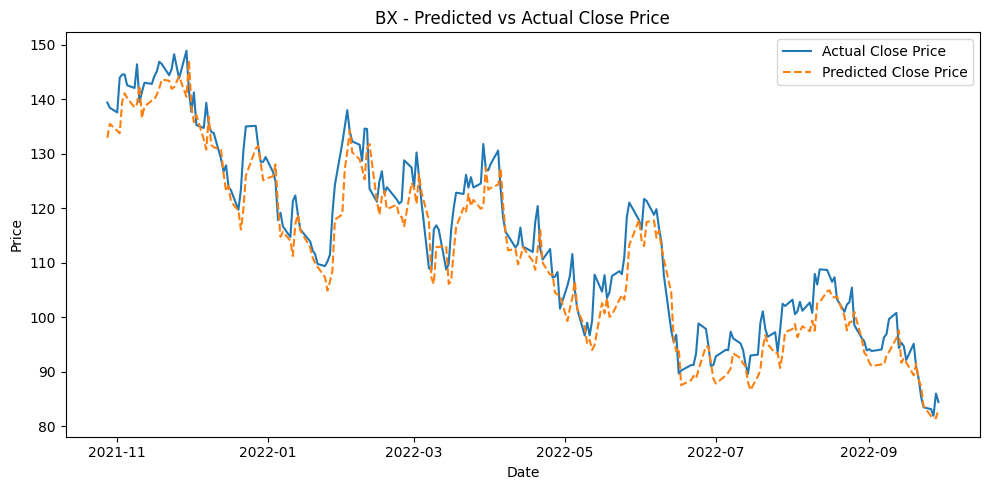

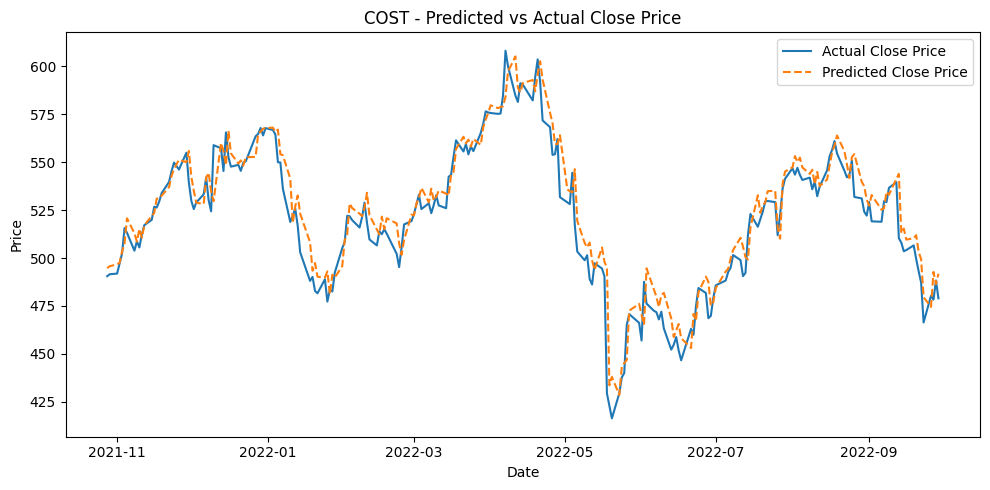

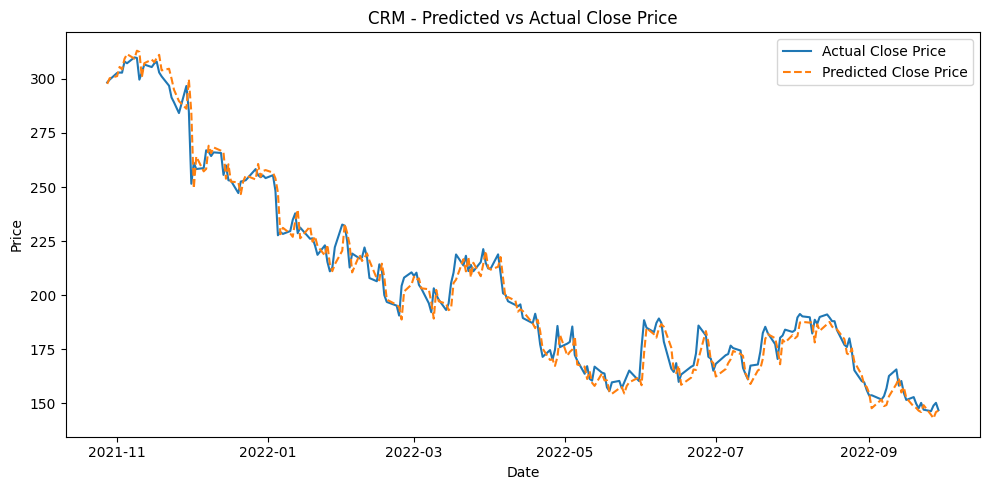

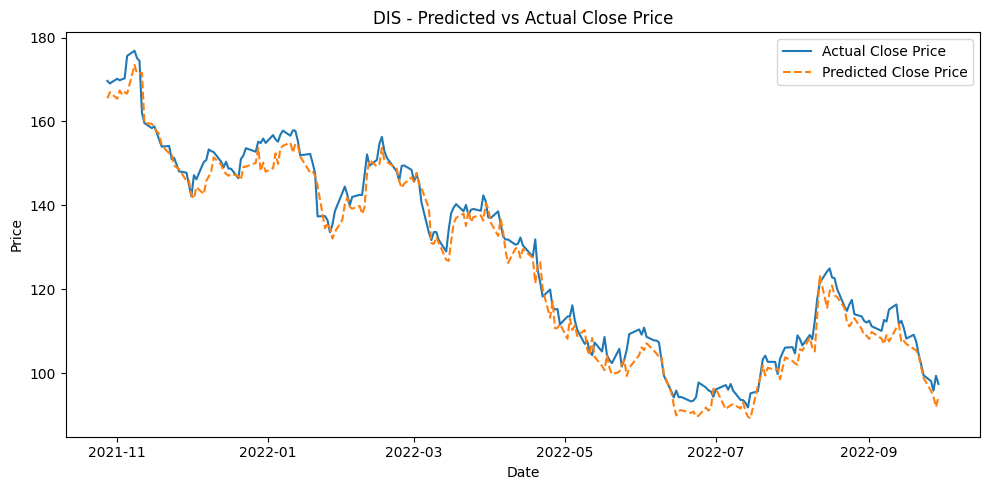

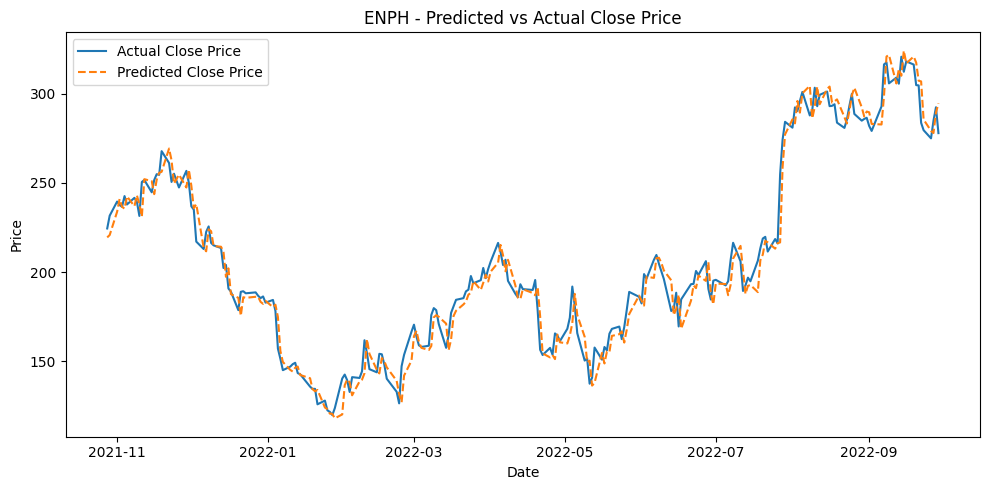

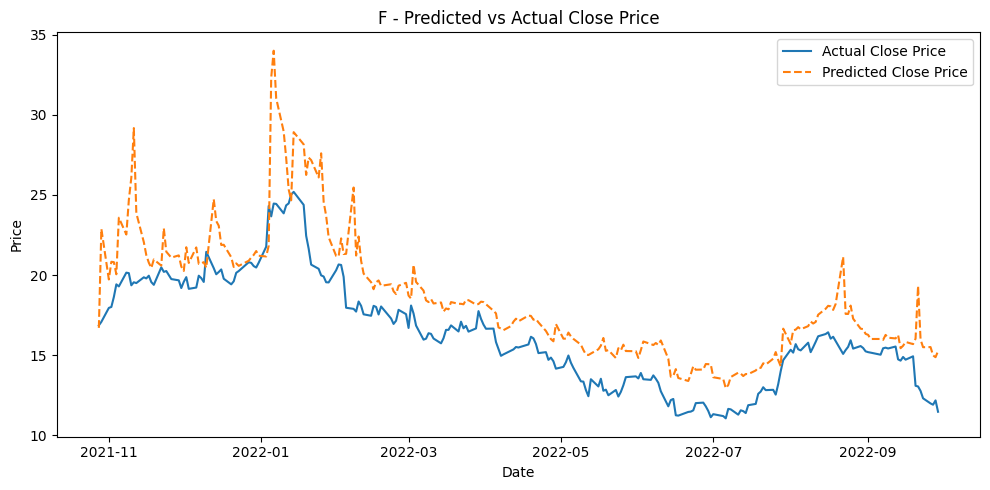

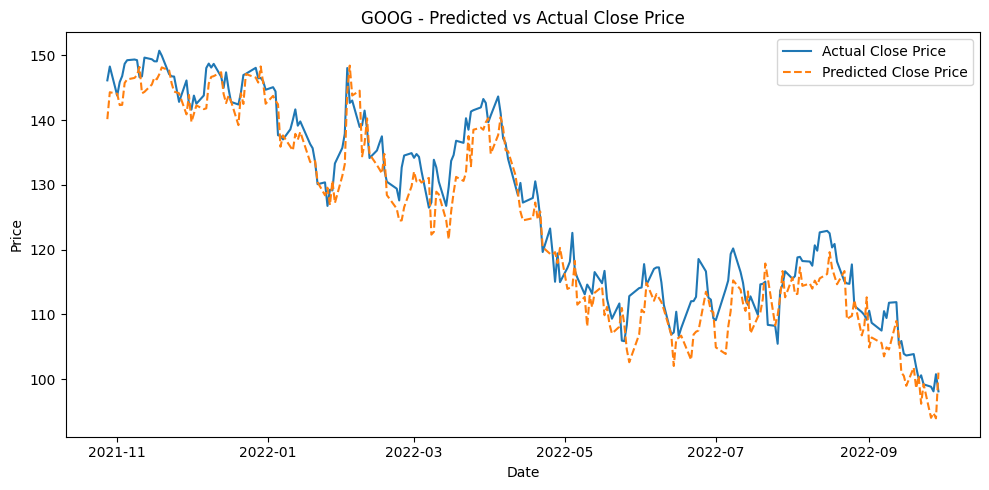

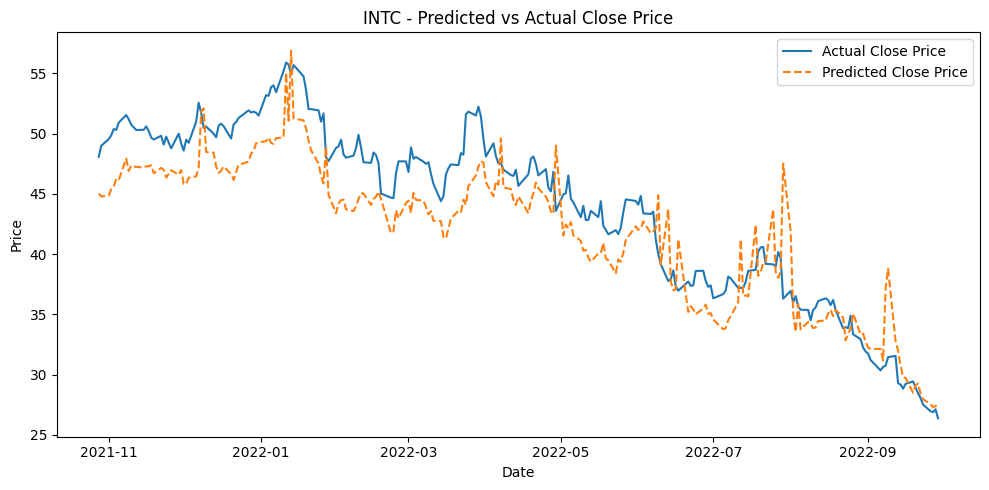

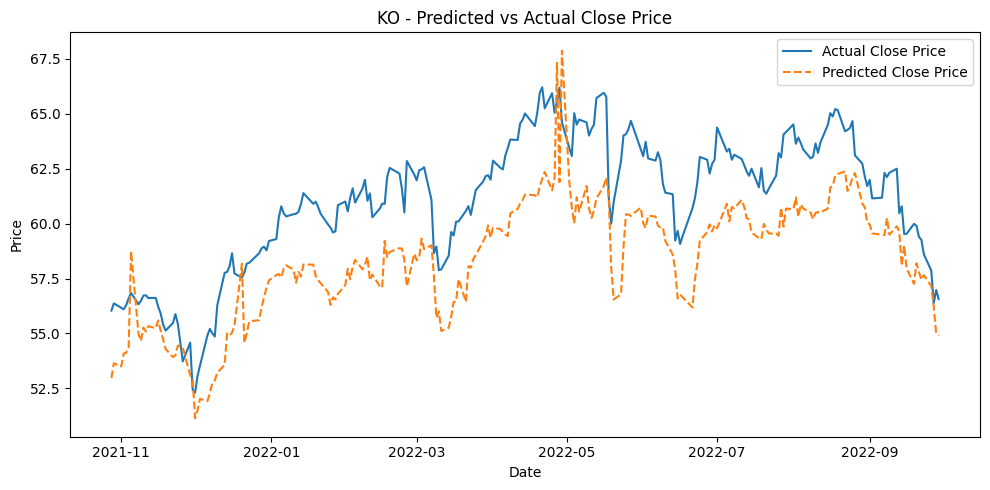

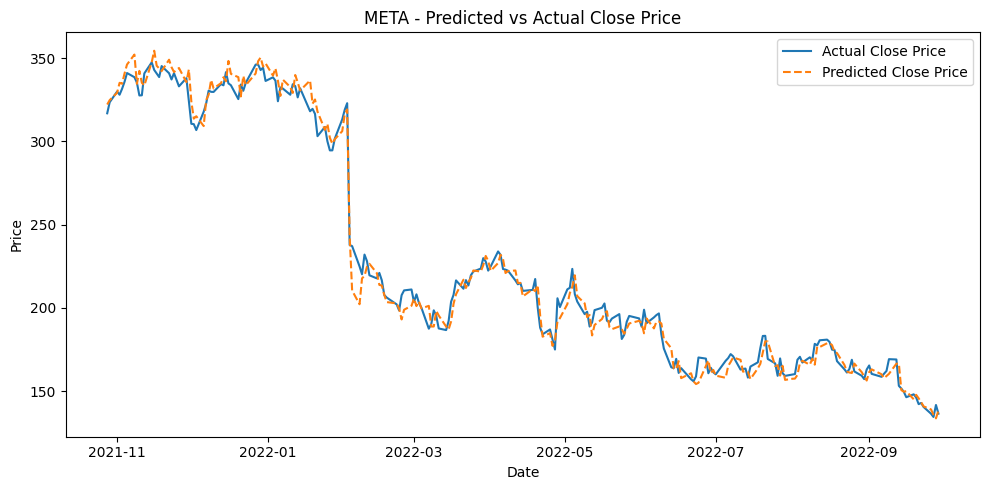

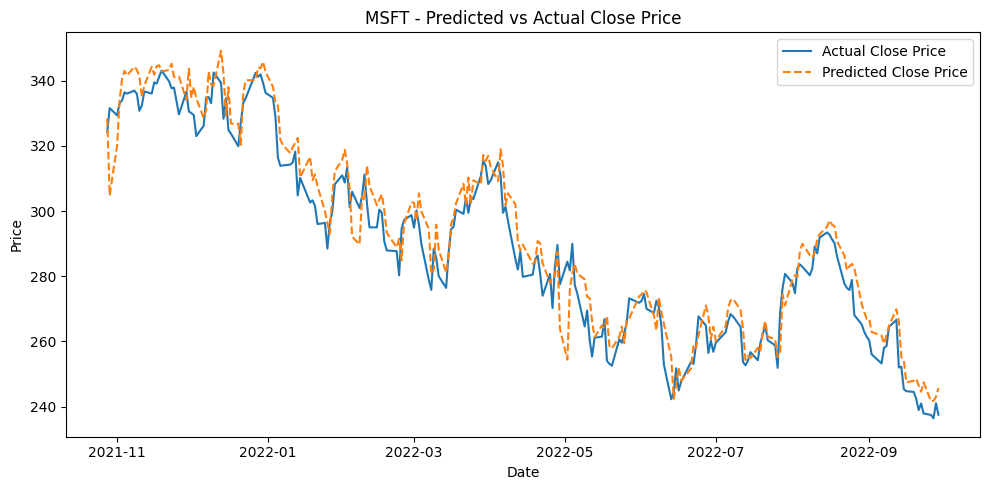

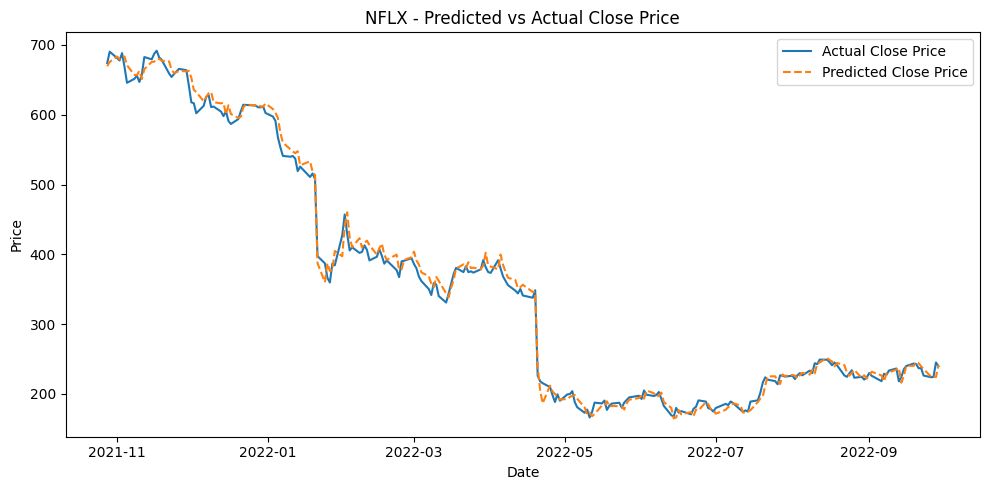

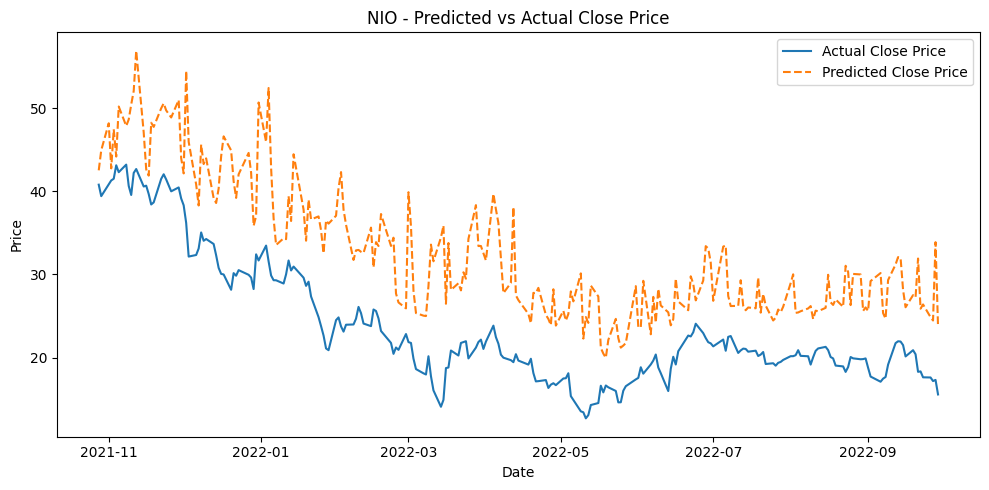

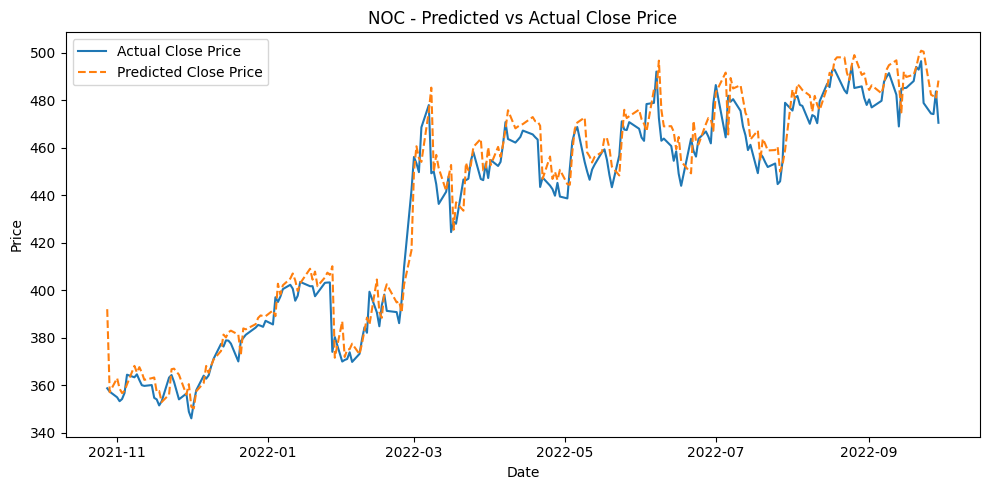

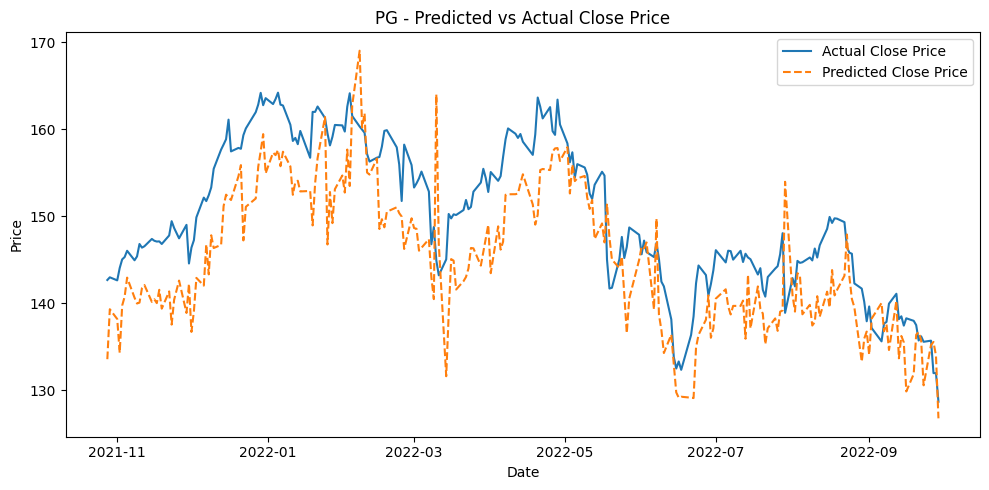

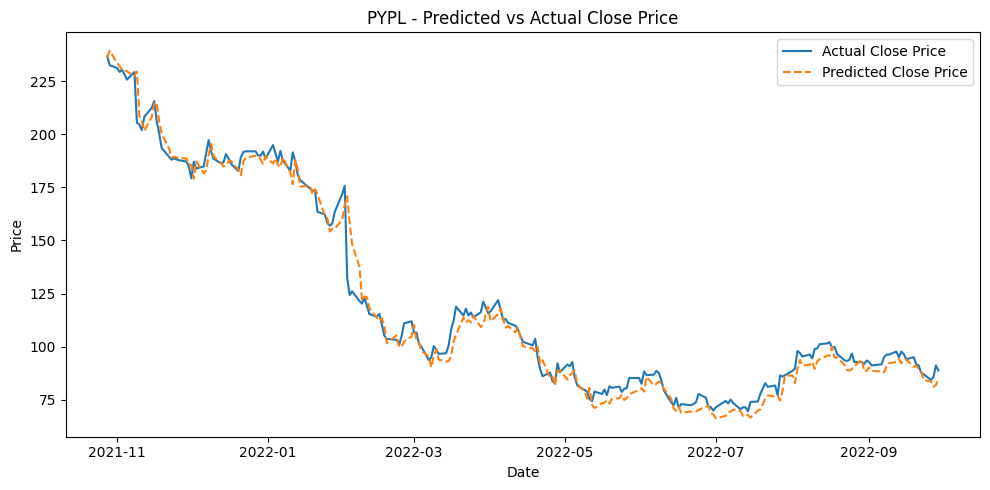

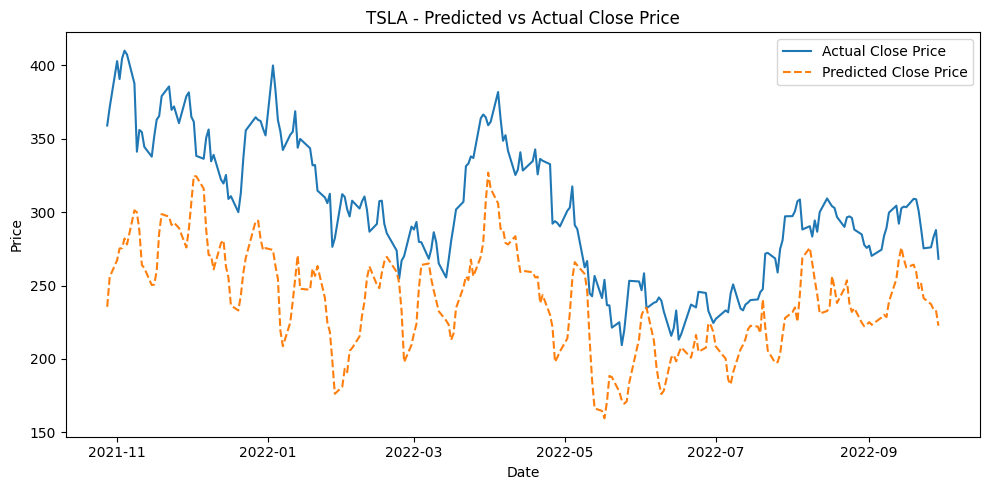

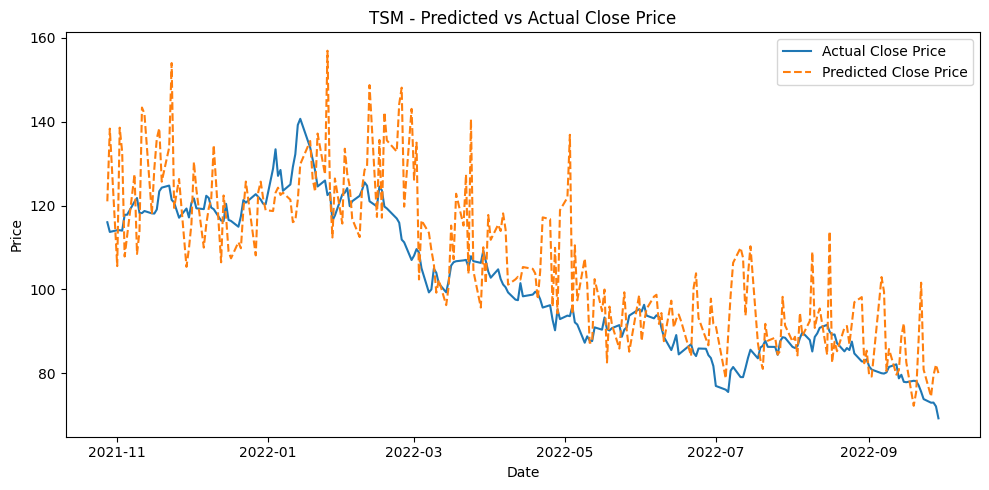

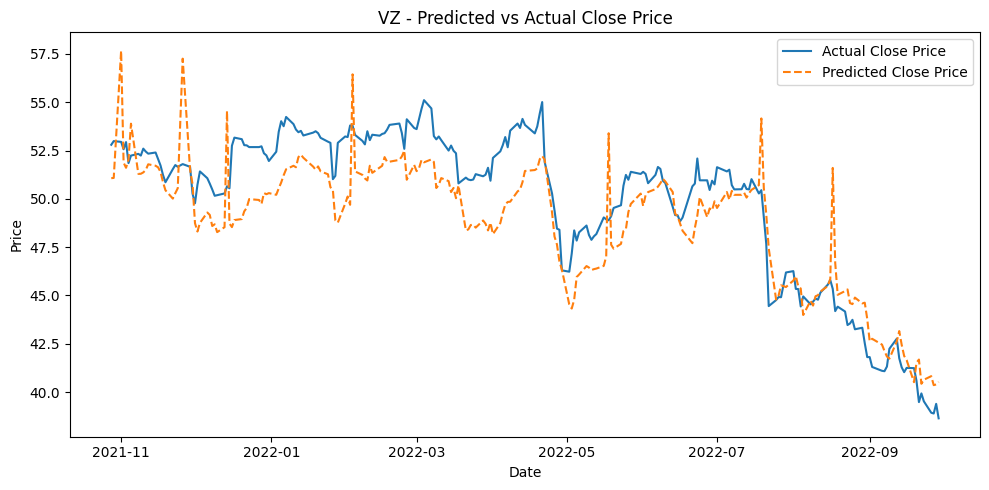

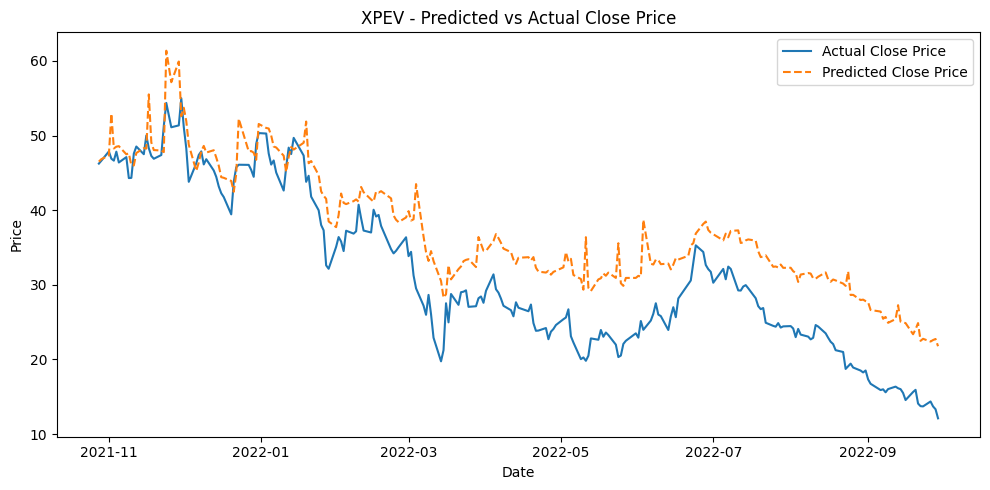

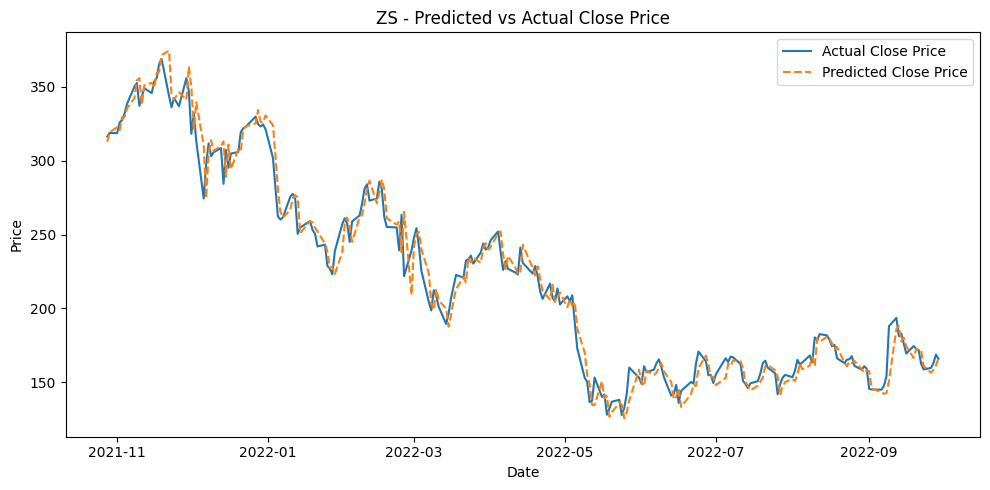

In [38]:
for stock in df['Stock Name'].unique():
    # 1. Extract and sort the group
    group = df[df['Stock Name'] == stock].sort_values('Date').reset_index(drop=True)
    
    # 2. Build sliding windows for this stock
    X_stock = []
    for i in range(len(group) - sequence_length):
        window = group.loc[i:i+sequence_length-1, feature_cols].values
        X_stock.append(window)
    X_stock = np.array(X_stock)  # shape: (n_seq, sequence_length, n_features)
    
    # 3. Predict (scaled) and inverse-transform
    y_pred_scaled = model.predict(X_stock, verbose=0)
    y_pred_raw = y_scaler.inverse_transform(y_pred_scaled).flatten()
    
    # 4. Actual raw closes aligned with predictions
    dates = group['Date'].iloc[sequence_length:].values
    y_actual = group['raw_Close'].iloc[sequence_length:].values
    
    # 5. Plot Predicted vs Actual
    plt.figure(figsize=(10, 5))
    plt.plot(dates, y_actual, label='Actual Close Price')
    plt.plot(dates, y_pred_raw, label='Predicted Close Price', linestyle='--')
    plt.title(f'{stock} - Predicted vs Actual Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

Stock Prediction Model Performance Metrics:
  Stock     MAE       MSE    RMSE      R² Max Error MAPE (%)
   AAPL  3.8275   23.4810  4.8457  0.8388   15.2082     2.39
    AMD  4.0354   24.6689  4.9668  0.9571   16.2687     3.80
   AMZN  3.7445   21.4561  4.6321  0.9596   11.0258     2.69
     BA  4.0820   28.5500  5.3432  0.9701   15.0534     2.42
     BX  3.8497   23.4833  4.8460  0.9147   13.1032     3.36
   COST  7.9182  118.2453 10.8741  0.9105   65.5267     1.55
    CRM  4.7155   39.2412  6.2643  0.9795   32.9711     2.35
    DIS  3.0681   14.4707  3.8040  0.9724   10.4622     2.47
   ENPH  6.9183   80.0728  8.9483  0.9714   38.1211     3.48
      F  2.1727    7.0908  2.6629  0.3596    9.6209    13.63
   GOOG  3.4100   17.0230  4.1259  0.9229   11.1455     2.75
   INTC  2.8033   10.5368  3.2460  0.7993   11.2046     6.24
     KO  2.7436    8.5725  2.9279  0.0576    6.0773     4.46
   META  5.3666   47.6103  6.9000  0.9898   26.7017     2.45
   MSFT  5.9429   54.9104  7.4102  0.9362

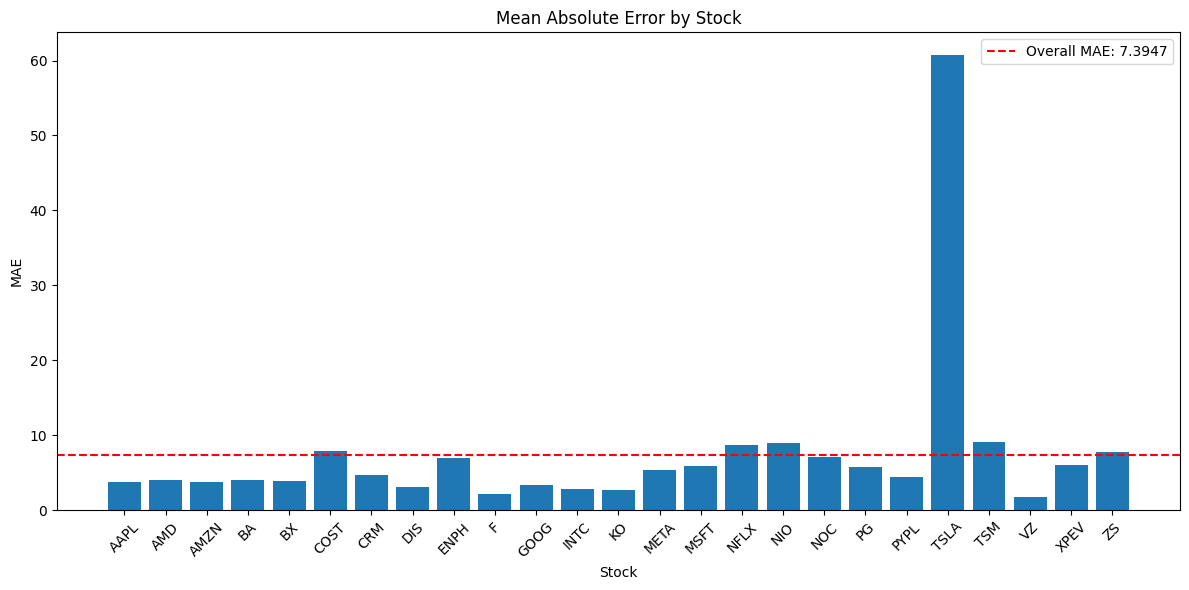

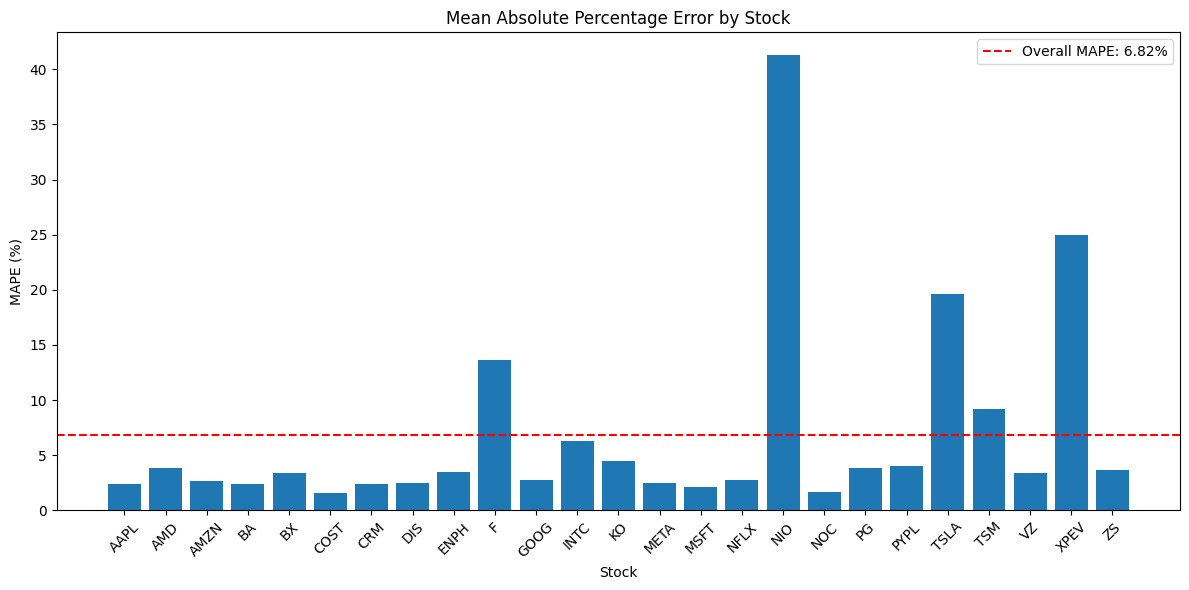

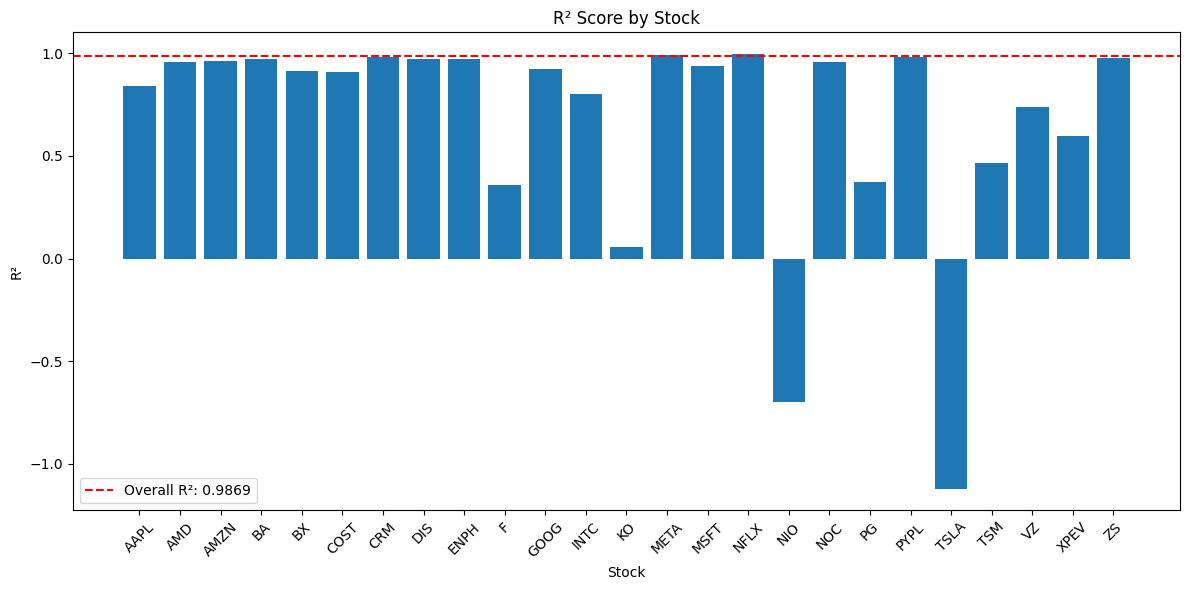

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error

# Dictionary to store metrics for each stock
stock_metrics = {}
all_actuals = []
all_preds = []

# Create a table for metrics
metrics_table = pd.DataFrame(columns=[
    'Stock', 'MAE', 'MSE', 'RMSE', 'R²', 'Max Error', 'MAPE (%)'
])

# Process each stock separately
for stock in df['Stock Name'].unique():
    # 1. Extract and sort the group
    group = df[df['Stock Name'] == stock].sort_values('Date').reset_index(drop=True)
    
    # 2. Build sliding windows for this stock
    X_stock = []
    for i in range(len(group) - sequence_length):
        window = group.loc[i:i+sequence_length-1, feature_cols].values
        X_stock.append(window)
    X_stock = np.array(X_stock)  # shape: (n_seq, sequence_length, n_features)
    
    # Skip if we don't have enough data for this stock
    if len(X_stock) == 0:
        print(f"Skipping {stock} - insufficient data")
        continue
    
    # 3. Predict (scaled) and inverse-transform
    y_pred_scaled = model.predict(X_stock, verbose=0)
    y_pred_raw = y_scaler.inverse_transform(y_pred_scaled).flatten()
    
    # 4. Actual raw closes aligned with predictions
    dates = group['Date'].iloc[sequence_length:].values
    y_actual = group['raw_Close'].iloc[sequence_length:].values
    
    # Store for overall metrics
    all_actuals.extend(y_actual)
    all_preds.extend(y_pred_raw)
    
    # 5. Calculate metrics for this stock
    mae = mean_absolute_error(y_actual, y_pred_raw)
    mse = mean_squared_error(y_actual, y_pred_raw)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_pred_raw)
    max_err = max_error(y_actual, y_pred_raw)
    mape = np.mean(np.abs((y_actual - y_pred_raw) / np.where(y_actual==0, 1, y_actual))) * 100
    
    # Add to our metrics table
    metrics_table = pd.concat([
        metrics_table,
        pd.DataFrame({
            'Stock': [stock],
            'MAE': [f"{mae:.4f}"],
            'MSE': [f"{mse:.4f}"],
            'RMSE': [f"{rmse:.4f}"],
            'R²': [f"{r2:.4f}"],
            'Max Error': [f"{max_err:.4f}"],
            'MAPE (%)': [f"{mape:.2f}"]
        })
    ], ignore_index=True)
    
    # Store metrics for this stock
    stock_metrics[stock] = {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'max_error': max_err,
        'mape': mape
    }

# Calculate overall metrics
overall_mae = mean_absolute_error(all_actuals, all_preds)
overall_mse = mean_squared_error(all_actuals, all_preds)
overall_rmse = np.sqrt(overall_mse)
overall_r2 = r2_score(all_actuals, all_preds)
overall_max_err = max_error(all_actuals, all_preds)
overall_mape = np.mean(np.abs((np.array(all_actuals) - np.array(all_preds)) / 
                              np.where(np.array(all_actuals)==0, 1, np.array(all_actuals)))) * 100

# Add overall metrics to the table
metrics_table = pd.concat([
    metrics_table,
    pd.DataFrame({
        'Stock': ['OVERALL'],
        'MAE': [f"{overall_mae:.4f}"],
        'MSE': [f"{overall_mse:.4f}"],
        'RMSE': [f"{overall_rmse:.4f}"],
        'R²': [f"{overall_r2:.4f}"],
        'Max Error': [f"{overall_max_err:.4f}"],
        'MAPE (%)': [f"{overall_mape:.2f}"]
    })
], ignore_index=True)

# Display the metrics table
print("Stock Prediction Model Performance Metrics:")
print(metrics_table.to_string(index=False))

# Create a bar chart to visualize MAE by stock
plt.figure(figsize=(12, 6))
stocks = list(stock_metrics.keys())
maes = [stock_metrics[s]['mae'] for s in stocks]
plt.bar(stocks, maes)
plt.axhline(y=overall_mae, color='r', linestyle='--', label=f'Overall MAE: {overall_mae:.4f}')
plt.title('Mean Absolute Error by Stock')
plt.xlabel('Stock')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Create a bar chart to visualize MAPE by stock
plt.figure(figsize=(12, 6))
stocks = list(stock_metrics.keys())
mapes = [stock_metrics[s]['mape'] for s in stocks]
plt.bar(stocks, mapes)
plt.axhline(y=overall_mape, color='r', linestyle='--', label=f'Overall MAPE: {overall_mape:.2f}%')
plt.title('Mean Absolute Percentage Error by Stock')
plt.xlabel('Stock')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Create a bar chart to visualize R² by stock
plt.figure(figsize=(12, 6))
stocks = list(stock_metrics.keys())
r2s = [stock_metrics[s]['r2'] for s in stocks]
plt.bar(stocks, r2s)
plt.axhline(y=overall_r2, color='r', linestyle='--', label=f'Overall R²: {overall_r2:.4f}')
plt.title('R² Score by Stock')
plt.xlabel('Stock')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Stock Tweets Dataset Summary
--------------------------
Total number of tweets: 80793
Date range: 2021-09-30 to 2022-09-29
Number of unique stocks mentioned: 25
Unique stocks: AAPL, AMD, AMZN, BA, BX, COST, CRM, DIS, ENPH, F, GOOG, INTC, KO, META, MSFT, NFLX, NIO, NOC, PG, PYPL, TSLA, TSM, VZ, XPEV, ZS

Tweet Count per Stock:
Stock  Tweet Count
 TSLA        37422
  TSM        11034
 AAPL         5056
 AMZN         4089
 MSFT         4089
   PG         4089
  NIO         3021
 META         2751
  AMD         2227
 NFLX         1727
 GOOG         1291
 PYPL          843
  DIS          635
   BA          399
 COST          393
 INTC          315
   KO          310
  CRM          233
 XPEV          225
 ENPH          216
   ZS          193
   VZ          123
   BX           50
    F           31
  NOC           31

Sentiment Analysis by Stock:
Stock  Total Positive  Avg Positive  Total Negative  Avg Negative  Total Neutral  Avg Neutral Dominant Sentiment
 AAPL          3639.8         0.720

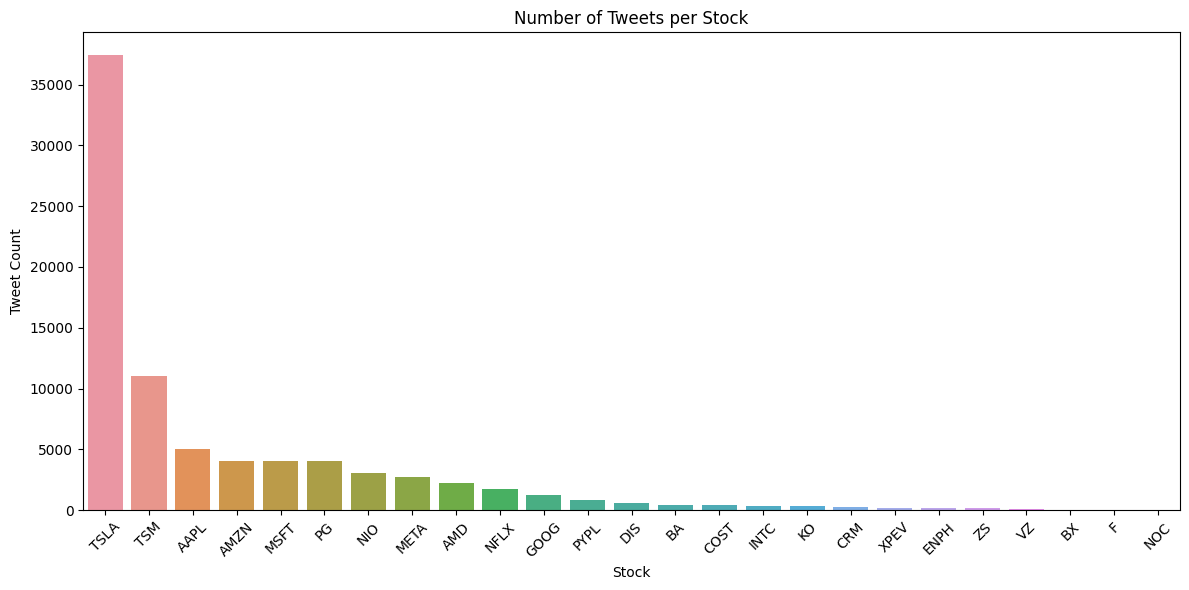

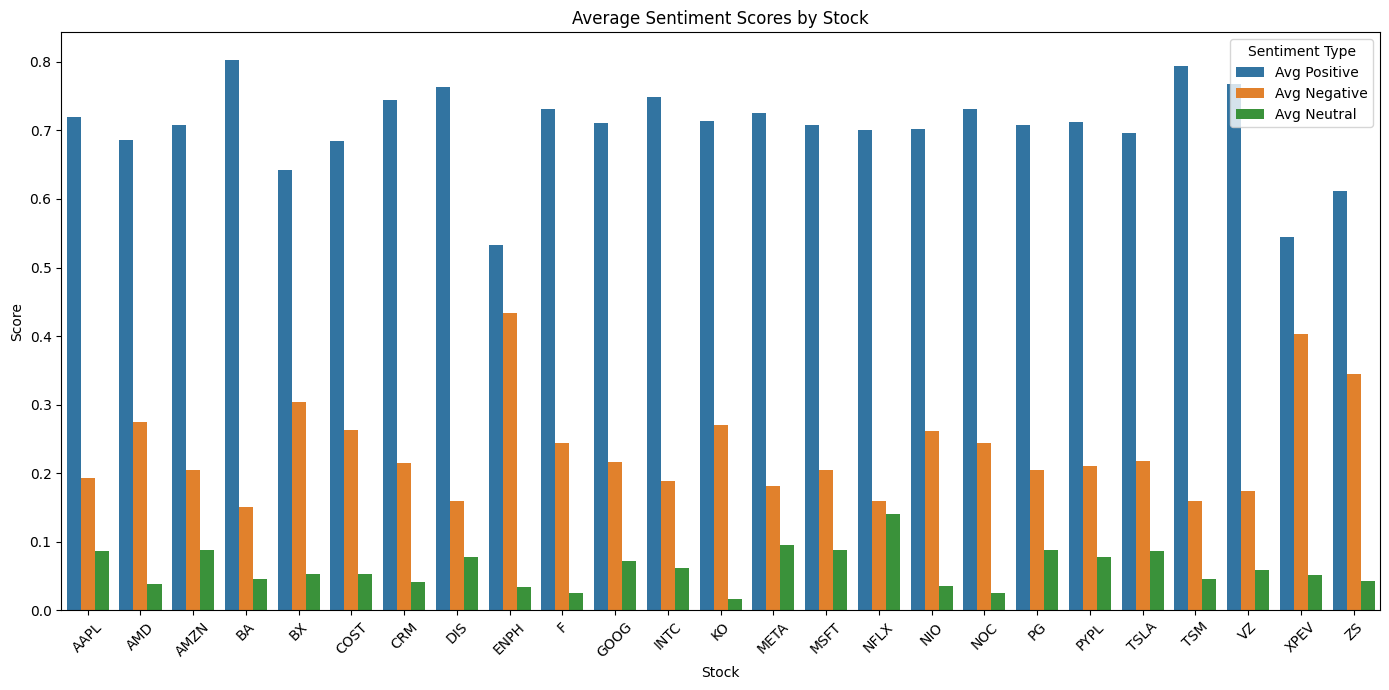

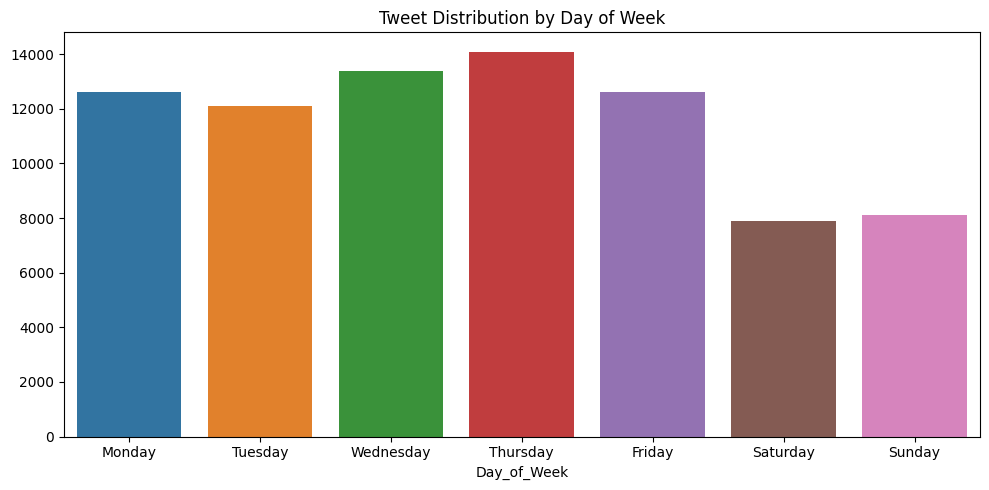

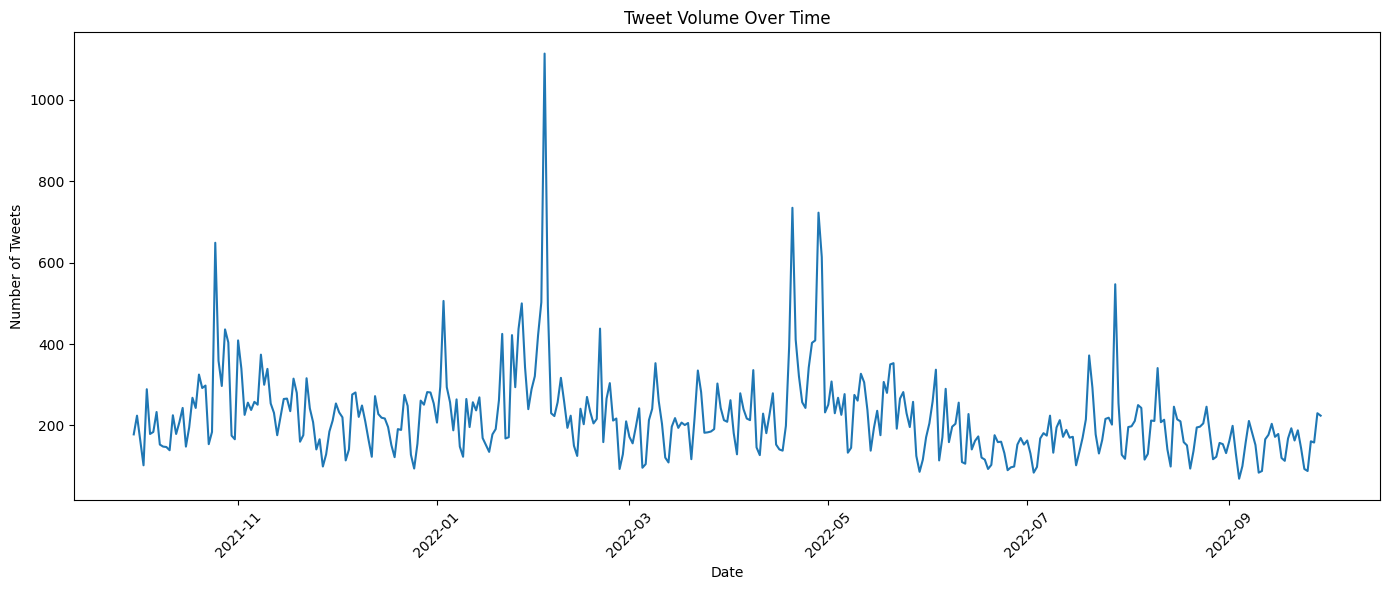

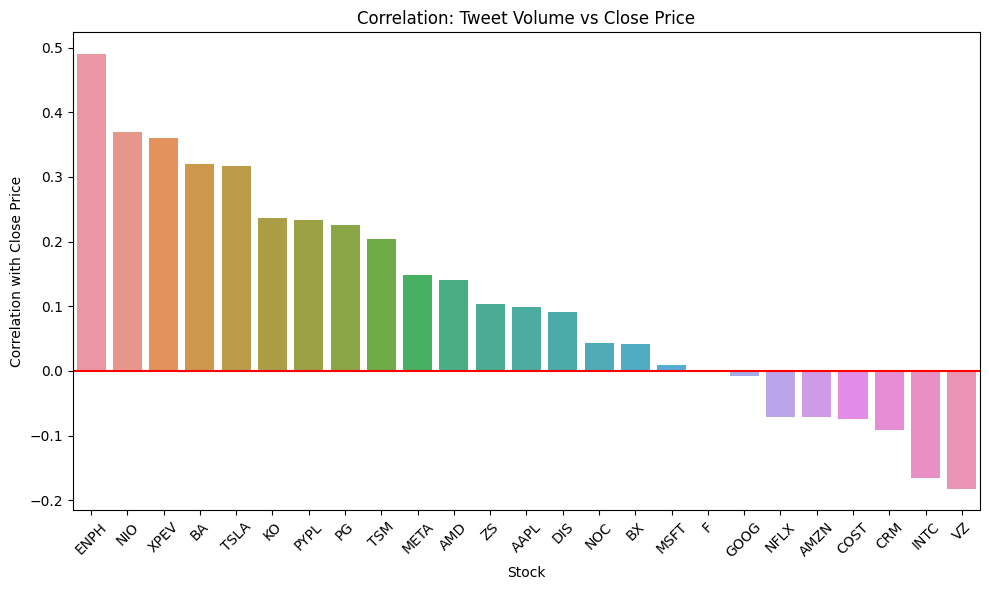

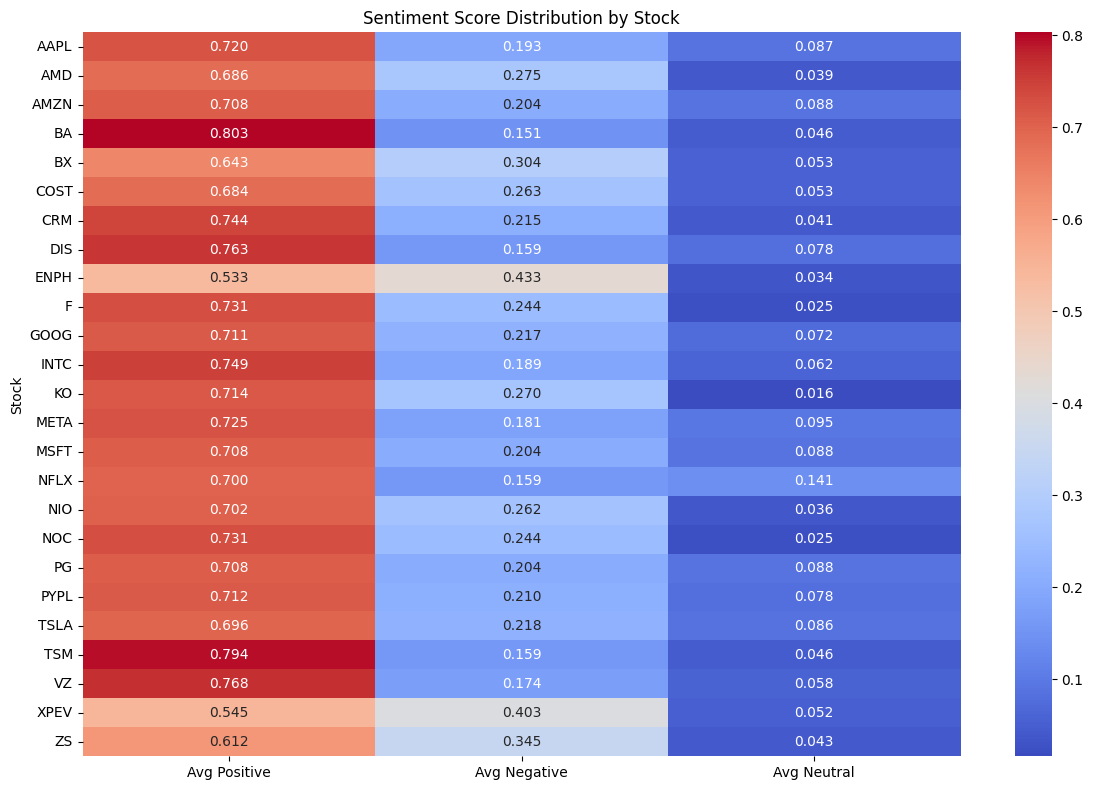

In [40]:
# Data metrics analysis for stock tweets dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming tweets_df and yfinance_df are already loaded
# If not, uncomment these lines:
# tweets_df = pd.read_csv('/kaggle/input/stock-tweets-for-sentiment-analysis-and-prediction/stock_tweets.csv')
# yfinance_df = pd.read_csv('/kaggle/input/stock-tweets-for-sentiment-analysis-and-prediction/stock_yfinance_data.csv')

# 1. Basic dataset information
print("Stock Tweets Dataset Summary")
print("--------------------------")
print(f"Total number of tweets: {len(tweets_df)}")
print(f"Date range: {tweets_df['Date_only'].min()} to {tweets_df['Date_only'].max()}")
print(f"Number of unique stocks mentioned: {tweets_df['Stock Name'].nunique()}")
print(f"Unique stocks: {', '.join(sorted(tweets_df['Stock Name'].unique()))}")

# 2. Tweet count per stock
tweet_counts = tweets_df['Stock Name'].value_counts().reset_index()
tweet_counts.columns = ['Stock', 'Tweet Count']
print("\nTweet Count per Stock:")
print(tweet_counts.to_string(index=False))

# 3. Calculate average sentiment scores per stock
sentiment_by_stock = tweets_df.groupby('Stock Name').agg({
    'fin_pos': ['sum', 'mean'],
    'fin_neg': ['sum', 'mean'],
    'fin_neu': ['sum', 'mean']
}).reset_index()
sentiment_by_stock.columns = [
    'Stock', 'Total Positive', 'Avg Positive', 
    'Total Negative', 'Avg Negative',
    'Total Neutral', 'Avg Neutral'
]

# Calculate dominant sentiment for each stock
dominant_sentiment = []
for _, row in sentiment_by_stock.iterrows():
    sentiments = {
        'Positive': row['Avg Positive'],
        'Negative': row['Avg Negative'],
        'Neutral': row['Avg Neutral']
    }
    dominant_sentiment.append(max(sentiments, key=sentiments.get))
sentiment_by_stock['Dominant Sentiment'] = dominant_sentiment

# Round values for better display
display_cols = ['Total Positive', 'Avg Positive', 'Total Negative', 'Avg Negative', 'Total Neutral', 'Avg Neutral']
for col in display_cols:
    if 'Avg' in col:
        sentiment_by_stock[col] = sentiment_by_stock[col].round(3)
    else:
        sentiment_by_stock[col] = sentiment_by_stock[col].round(1)

print("\nSentiment Analysis by Stock:")
print(sentiment_by_stock.to_string(index=False))

# 4. Calculate tweet distribution by day of week
tweets_df['Day_of_Week'] = pd.to_datetime(tweets_df['Date_only']).dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tweets_by_day = tweets_df['Day_of_Week'].value_counts().reindex(day_order).fillna(0)

print("\nTweet Distribution by Day of Week:")
for day, count in tweets_by_day.items():
    print(f"{day}: {int(count)} tweets")

# 5. Calculate tweet volume over time
tweets_by_date = tweets_df.groupby('Date_only').size().reset_index(name='Tweet Count')

# 6. Merge tweet volume with daily stock data to see potential correlation
# First get a count of tweets per stock per day
tweets_by_stock_date = tweets_df.groupby(['Stock Name', 'Date_only']).size().reset_index(name='Tweet Count')
# Then merge with yfinance data
merged_data = yfinance_df.merge(tweets_by_stock_date, on=['Stock Name', 'Date_only'], how='left')
merged_data['Tweet Count'] = merged_data['Tweet Count'].fillna(0)

# Calculate correlation between tweet volume and stock metrics
correlation_data = {}
for stock in merged_data['Stock Name'].unique():
    stock_data = merged_data[merged_data['Stock Name'] == stock]
    if len(stock_data) > 10:  # Only calculate if we have enough data
        corr = stock_data[['Tweet Count', 'Close']].corr().iloc[0, 1]
        correlation_data[stock] = corr

correlation_df = pd.DataFrame.from_dict(correlation_data, orient='index', columns=['Correlation'])
correlation_df = correlation_df.sort_values('Correlation', ascending=False).reset_index()
correlation_df.columns = ['Stock', 'Correlation with Close Price']
correlation_df['Correlation with Close Price'] = correlation_df['Correlation with Close Price'].round(3)

print("\nCorrelation between Tweet Volume and Close Price:")
print(correlation_df.to_string(index=False))

# 7. Visualizations

# Plot 1: Tweet counts by stock
plt.figure(figsize=(12, 6))
sns.barplot(x='Stock', y='Tweet Count', data=tweet_counts.sort_values('Tweet Count', ascending=False))
plt.title('Number of Tweets per Stock')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Average sentiment by stock
plt.figure(figsize=(14, 7))
sentiment_plot_data = pd.melt(
    sentiment_by_stock, 
    id_vars=['Stock'], 
    value_vars=['Avg Positive', 'Avg Negative', 'Avg Neutral'],
    var_name='Sentiment Type', 
    value_name='Score'
)
sns.barplot(x='Stock', y='Score', hue='Sentiment Type', data=sentiment_plot_data)
plt.title('Average Sentiment Scores by Stock')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Tweets by day of week
plt.figure(figsize=(10, 5))
sns.barplot(x=tweets_by_day.index, y=tweets_by_day.values)
plt.title('Tweet Distribution by Day of Week')
plt.tight_layout()
plt.show()

# Plot 4: Tweet volume over time
plt.figure(figsize=(14, 6))
plt.plot(tweets_by_date['Date_only'], tweets_by_date['Tweet Count'])
plt.title('Tweet Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 5: Correlation between tweet volume and closing price
plt.figure(figsize=(10, 6))
sns.barplot(x='Stock', y='Correlation with Close Price', data=correlation_df)
plt.title('Correlation: Tweet Volume vs Close Price')
plt.axhline(y=0, color='r', linestyle='-')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 6: Heatmap of sentiment distribution
# Create a pivot table of sentiment scores by stock
sentiment_heatmap = sentiment_by_stock[['Stock', 'Avg Positive', 'Avg Negative', 'Avg Neutral']]
sentiment_heatmap = sentiment_heatmap.set_index('Stock')

plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_heatmap, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Sentiment Score Distribution by Stock')
plt.tight_layout()
plt.show()